# **1.0 Importing Libraries and Packages** 

In [1]:
import os
import numpy as np
import pandas as pd


import scipy
from scipy.fft import fft
from scipy.signal import welch
from scipy import stats

import pywt

from collections import Counter

import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, SpatialDropout1D, BatchNormalization, Embedding, Activation, Input, concatenate
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D, SpatialDropout2D
from tensorflow.keras.optimizers import Adam, Adadelta, SGD, Adagrad, RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import History 

!pip install mne
import mne
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap)

!pip install autoreject
from autoreject import get_rejection_threshold
from autoreject import AutoReject

!pip install detecta
from detecta import detect_peaks


os.chdir('C:/Users/dkornev/Desktop/Work Folder/My Folders/Harrisburg University/ISEM 780-52-A-2021 Fall - Doctoral Research Seminar/Experiment_1')
os.getcwd()

  Using cached matplotlib-3.7.0-cp38-cp38-win_amd64.whl (7.7 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.3
    Uninstalling matplotlib-3.1.3:
      Successfully uninstalled matplotlib-3.1.3


'C:\\Users\\dkornev\\Desktop\\Work Folder\\My Folders\\Harrisburg University\\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\\Experiment_1'

In [2]:
!pip install matplotlib==3.1.3
import matplotlib.pyplot as plt

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autoreject 0.4.0 requires matplotlib>=3.3, but you have matplotlib 3.1.3 which is incompatible.


  Using cached matplotlib-3.1.3-cp38-cp38-win_amd64.whl (9.1 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.0
    Uninstalling matplotlib-3.7.0:
      Successfully uninstalled matplotlib-3.7.0


# **2.0 Functions** 

## **2.1 IGT Function** 

## **2.2 Trigger Events Function** 

In [3]:
def EVENTS(a):
    a = a.TL02.str.split(r'\t', expand=True) # dividing by columns; !!!the whole dataset is more than 200 trials (201)!!!
    a.columns = ['Time', 'Time1', 'Mark'] # rename columns
    a.drop('Time1', axis = 1, inplace = True) # drop colunm "0"

    # Sort decision time points (DTP) only and dividing by 10 Blocks
    igt1 = a[(a.Mark == '"PP 1"') | (a.Mark == '"PP 2"') | (a.Mark == '"PP 3"') | (a.Mark == '"PP 4"')]
    igt1.columns = ['DTP', 'Deck']
    igt1 = igt1.reset_index(drop = True)
    igt1['Block'] = pd.DataFrame(np.repeat(np.arange(0, 10), 20))
    
    # Sort reaction time points (RTP)
    # PP9 - win
    # PP10 - loss
    igt2 = a[(a.Mark == '"PP 9"') | (a.Mark == '"PP 10"')]
    igt2.columns = ['RTP', 'Result']
    igt2 = igt2.reset_index(drop = True)

    # The whole IGT dataset
    igt = igt1.join(igt2)
    igt = igt.dropna(axis=0, how='any') # erasing NaN rows
    igt = igt.drop_duplicates(keep='first', subset='RTP') # duplicates in rows deliting

    # Rename decks and results
    igt['RTP'] = igt['RTP'].astype(str).astype(int)
    igt['DTP'] = igt['DTP'].astype(str).astype(int)
    igt.loc[(igt.Deck == '"PP 1"'), 'Deck'] = 'A'
    igt.loc[(igt.Deck == '"PP 2"'), 'Deck'] = 'B'
    igt.loc[(igt.Deck == '"PP 3"'), 'Deck'] = 'C' 
    igt.loc[(igt.Deck == '"PP 4"'), 'Deck'] = 'D'
    igt.loc[(igt.Result == '"PP 9"'), 'Result'] = '1' 
    igt.loc[(igt.Result == '"PP 10"'), 'Result'] = '0'
    
    # Events (triggers) list creation
    igt['Tmax'] = igt['RTP'] + 800 # RTP is 0 point of trigger event, Tmax is the END point of the trigger event
    igt['Tmin'] = igt['RTP'] - 200 # RTP is 0 point of trigger event, Tmin is the START point of the trigger event
    events = igt[['Deck', 'Tmin', 'Tmax']]
    events = events.melt(id_vars=['Deck'], value_vars=['Tmin', 'Tmax'])
    events.drop('Deck', axis = 1, inplace = True)
    events.columns = ['point', 'time']
    events = events.sort_values(by=['time'])
    
    Tmin = events[(events.point == 'Tmin')]
    Tmax = events[(events.point == 'Tmax')]
    Tmax = Tmax.reset_index(drop = True)
    Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))
    Tmax['index'] = pd.DataFrame(np.arange(2001, 3001))
    events = pd.concat([Tmin, Tmax])
    events = events.reset_index(drop = True)
    events = events.sort_values(by=['time'])   
    # For following synchronization with EEG dataset EVENTS data should be adjusted by adding an appropriate columns
    
    # Set of triggers events (time window intervals) creation: 200 card selections by 1001 time points, total 200200 rows     
    intervals = pd.concat([pd.DataFrame([i], columns=['point']) for i in range(1001)]*200, ignore_index=True)
    intervals.loc[intervals.point == 0, 'point'] = '01Tmin'
    intervals.loc[intervals.point == 1000, 'point'] = '02Tmax'
    intervals['int'] = pd.DataFrame(np.arange(0, 200200)) 
    
    # Rename Tmin and Tmax points for following sorting
    intervals['point'] = intervals['point'].astype(str)
    
    # now we have the first 200 rows of Tmin (01Tmin) and the second 200 rows of Tmax (02Tmax) 
    # for following numbering simplification
    intervals = intervals.sort_values(by=['point', 'int'])
    intervals = intervals.reset_index(drop = True)
    
    # Adding new column "index" for numbering Tmin and Tmax
    A = [np.arange(1001, 1201)]
    B = [np.arange(2001, 2201)]
    AA = pd.DataFrame(A).T
    BB = pd.DataFrame(B).T
    C = pd.concat([AA, BB])
    C = C.reset_index(drop = True)
    intervals = intervals.join(C)
    intervals.columns = ['point', 'int', 'index']
    intervals = intervals.fillna(0)
    # Now we have individual indexes for each Tmin and Tmax
    
    # Sort back to 1 - 200200 by "int" column
    intervals = intervals.sort_values(by=['int'])
    intervals['index'] = intervals['index'].astype(int)
    
    # Rename points back
    intervals.loc[(intervals.point == '01Tmin'), 'point'] = 'Tmin' 
    intervals.loc[(intervals.point == '02Tmax'), 'point'] = 'Tmax'
    
     # Creation trigger events dataset
    
    events_triggers = intervals.merge(events, how = 'left', on = 'index') # merge EVENTS and INTERVALS
    
    events_triggers = events_triggers.reset_index(drop = True)
    events_triggers = events_triggers[['point_x', 'time']] # taking just two columns
    events_triggers.columns = ['intervals', 'time'] # renaming columns to "INTARVALS" and "TIME"

    events_triggers['time3'] = events_triggers['time']
    events_triggers['time3'].fillna(method='bfill', inplace=True) # filling NaN as the lower  number

    events_triggers = events_triggers.dropna(subset=['time3'])# drop NaN by the column

    events_triggers['time4'] = events_triggers['time']

    events_triggers = events_triggers.fillna(method='ffill') # filling NaN as the upper number

    events_triggers['intervals2'] = events_triggers['intervals']
    events_triggers.loc[(events_triggers.intervals2 == 'Tmin'), 'intervals2'] = '0' 
    events_triggers.loc[(events_triggers.intervals2 == 'Tmax'), 'intervals2'] = '0' 
    events_triggers['intervals2'] = events_triggers['intervals2'].astype(int)

    events_triggers['time5'] = events_triggers['time4'] + events_triggers['intervals2']
    events_triggers = events_triggers[['intervals', 'time5']]
    events_triggers.columns = ['intervals', 'time']
 
    return events_triggers

## **2.3 EEG Filtering Function** 

In [4]:
def FILTER_40(file_eeg):
    file_eeg.load_data()

    # Filtering: low-pass 0.1Hz, High-pass 40Hz
    file_eeg_filt_notch = file_eeg.copy().notch_filter(50, verbose='warning')  # notch filter 50 Hz
    file_eeg_filt = file_eeg_filt_notch.filter(l_freq=0.1, h_freq=40, fir_design='firwin', skip_by_annotation='edge', verbose='warning') # FIR filter

    return file_eeg_filt

In [5]:
def FILTER_ICA(file_eeg):
    file_eeg.load_data()

    # Filtering: low-pass 1Hz, High-pass 30Hz
    file_eeg_filt_ica = file_eeg.copy().filter(l_freq=1, h_freq=40, fir_design='firwin', skip_by_annotation='edge', verbose='warning') # FIR filter

    return file_eeg_filt_ica

## **2.4 EEG ICA Function** 

In [6]:
def REJECT(file_eeg_filt_ica):
  tstep = 1.0         # Break raw data into 1 s epochs
  events_ica = mne.make_fixed_length_events(file_eeg_filt_ica, duration=tstep)
  epochs_ica = mne.Epochs(file_eeg_filt_ica, events_ica,
                        tmin=0.0, tmax=tstep,
                        baseline=None,
                        preload=True)

  return epochs_ica

In [7]:
def ICA_REJECT_99(epochs_ica):
  reject_thr = get_rejection_threshold(epochs_ica)
  print('rejection threshold: ', reject_thr)
  ica = ICA(n_components=0.99, max_iter='auto', random_state=97, method='fastica')
  ica.fit(epochs_ica, reject=reject_thr, tstep=1.0)

  return ica

## **2.5 IGT and EEG Synchronization Function** 

In [8]:
def EEG(eeg_data, igt_trigger):    
    # The whole dataset creation connecting trigger events with eeg levels by time points
    S = eeg_data.join(igt_trigger.set_index('time'), on='time')
    S = S.dropna(axis=0, how='any') # erasing NaN rows
    S = S.reset_index(drop = True)
    
    # preparing dataset for following PIVOT function application
    # adding 'EPOCHS' column that reflects 200 epochs (each for each card choice) with 1001 time points
    S['epochs'] = pd.DataFrame(np.repeat(np.arange(0, 200), 1001))
    S.loc[(S.intervals == 'Tmin'), 'intervals'] = '0' 
    S.loc[(S.intervals == 'Tmax'), 'intervals'] = '1000' 
    S['intervals'] = S['intervals'].astype(int)

    # Dataset transformation, matching (Tmin, -199, -198, ..., -1, RTP(0), 1, 2,3, ....., 788, 789, Tmax) points
    S = S.pivot(index='epochs', columns='intervals', values='level')
    S = S.reset_index(drop = True)
    S_T = S.T
    S_T = S_T.reset_index(drop = True)
    S_T_T = S_T.T
    S_T_T = S_T_T.reset_index(drop = True)
    S_T_T_T = S_T_T.T
    
    return S_T_T_T

In [9]:
# Combining 20 EEG datasets in one. Averaging
def TOTAL(a):
    a_mean = a.mean(axis=1)
    
    
    return a_mean

In [10]:
def FRAME(ica):
  file_eeg_filt_mod = ica.to_data_frame()
  file_eeg_filt_mod.drop('time', axis = 1, inplace = True)
  
  # Signal averaging by channels
  file_eeg_filt_mod['level'] = file_eeg_filt_mod.mean(axis=1)
  file_eeg_filt_mod_mean = file_eeg_filt_mod['level']
  file_eeg_filt_mod_mean = file_eeg_filt_mod_mean.to_frame()
  file_eeg_filt_mod_mean['time'] = file_eeg_filt_mod_mean.index
  
  return file_eeg_filt_mod_mean

## **2.6 EEG Plot Function** 

In [11]:
def EEG_PLOT(a):
  a_mean = a.to_frame()
  a_mean['Time'] = pd.DataFrame(np.arange(-200, 801))
  a_mean.columns = ['Level', 'Time']

  plt.figure(figsize=(20, 6))
  
  plt.plot(a_mean['Time'], a_mean['Level'])

  plt.hlines(0, -200, 800, colors='black', linestyles='dashed')
  plt.vlines(0, -3.3, 2.7, colors='black', linestyles='dashed')
  plt.grid()
  plt.xlabel('Time, [ms]', size='15')
  plt.ylabel('Level, [$\mu V$]', size='15')
  y = np.arange(-3.3, 3.3)
  plt.fill_betweenx(y,  80, 180, alpha=0.2)
  plt.fill_betweenx(y, 180, 280, alpha=0.2)
  plt.fill_betweenx(y, 280, 360, alpha=0.2)
  plt.fill_betweenx(y, 360, 480, alpha=0.2)
  plt.fill_betweenx(y, 480, 600, alpha=0.2)
  plt.yticks(fontsize=13)
  plt.xticks(np.arange(-200, 801, step=100), fontsize=13)

  plt.show()

  return

## **2.7 EEG Digitizing Function** 

In [12]:
builtin_montages = mne.channels.get_builtin_montages()
easycap_montage = mne.channels.make_standard_montage('easycap-M1')

In [13]:
def DIGITIZING_IO(file_eeg):
  file_eeg.set_channel_types({'Fp1': 'eeg'})
  file_eeg.set_montage(easycap_montage)

  return file_eeg

In [14]:
def DROP_CHANNELS_IO(file_eeg):
  file_eeg.drop_channels(['IO', 'FT9', 'FT7', 'T7', 'TP7', 'TP9', 'FC5', 'CP5', 'FT10', 'FT8', 'T8', 'TP8', 'TP10', 'FC6', 'CP6'])

  return file_eeg

## **2.8 Artifacts Removing** 

In [15]:
def ARTIFACTS_REMOVING_IO(ica, file_eeg_filt):
  muscle_idx, muscle_scores = ica.find_bads_muscle(file_eeg_filt,        # muscle artifacts
                                                   h_freq=40, 
                                                   verbose='warning')              
  eog_idx,       eog_scores = ica.find_bads_eog(file_eeg_filt,           # eog artifacts
                                                ch_name=['Fp1', 'F8'], 
                                                h_freq=30, 
                                                verbose='warning')  
  ecg_idx                   = [0, 1, 2]                                   # ecg artifacts
                                                
  file_eeg_filt_clean = ica.apply(file_eeg_filt, exclude = eog_idx + ecg_idx + muscle_idx)

  return file_eeg_filt_clean

# **3.0 Data Loading** 

In [16]:
def get_dataset(file_igt, file_eeg):
    print('')
    print('')
    print('Files Loading: ', file_igt, file_eeg)
    igt = pd.read_csv(file_igt)                  # reading IGT data
    
    events = EVENTS(igt)                         # trigger-events file creation

    file_raw = mne.io.read_raw_edf(file_eeg)     # reading EEG data
        
    raw = DROP_CHANNELS_IO(file_raw)
    eeg = DIGITIZING_IO(raw)
    
    print('')
    print('=== FILTER ===')
    file_eeg_filt = FILTER_40(eeg)              # EEG filtering
    print('')
    print('=== REJECT ===')  
    file_eeg_filt_ica = FILTER_ICA(eeg)         # EEG ICA filter
    file_eeg_filt_reject = REJECT(file_eeg_filt_ica)
    print('')
    print('=== ICA ===')
    file_eeg_filt_reject_ica = ICA_REJECT_99(file_eeg_filt_reject)
    print('')
    print('=== ARTIFACTS ===')
    file_eeg_filt_reject_ica_clean = ARTIFACTS_REMOVING_IO(file_eeg_filt_reject_ica, file_eeg_filt)
    print('')
    print('=== PLOT ===')
    file_eeg_filt_reject_ica_clean_frame = FRAME(file_eeg_filt_reject_ica_clean)
    EEGdata = EEG(file_eeg_filt_reject_ica_clean_frame, events) 
    EEGdata_avg = TOTAL(EEGdata)
    EEG_PLOT(EEGdata_avg)
  
    return EEGdata

# **4.0 Features Extraction** 

In [17]:
def get_fft_values(signal, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(signal)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values
      
def get_psd_values(signal, T, N, f_s):
    f_values, psd_values = welch(signal, fs=f_s)
    return f_values, psd_values

def acf(x):
    result = np.correlate(x, x, mode='full')
    return result[len(result)//2:]

def get_acf_values(signal, T, N, f_s):
    acf_values = acf(signal)
    x_values = np.array([T * jj for jj in range(0, N)])
    return x_values, acf_values
    
def get_first_n_peaks(x, y, n_peaks): 
    x_, y_ = list(x), list(y)
    if len(x_) >= n_peaks:
        return x_[:n_peaks], y_[:n_peaks]
    else:
        missing_n_peaks = n_peaks-len(x_)
        return x_ + [0]*missing_n_peaks, y_ + [0]*missing_n_peaks 
    
def get_features_peaks(x_values, y_values, mph, n_peaks):
    indices_peaks = detect_peaks(y_values, mph=mph)
    peaks_x, peaks_y = get_first_n_peaks(x_values[indices_peaks], y_values[indices_peaks], n_peaks)
    return peaks_x + peaks_y

def extract_features_signal(signal, percentile, denominator, n_peaks):
    t_n = 1
    N = len(signal)
    T = t_n / N
    f_s = 1/T 
    
    cwt_waveletname = 'morl' 
    dwt_waveletname = 'db4' 
    denominator = 10 
    percentile = 5 
    n_peaks = 50
        
    features = []
    signal_min = np.nanpercentile(signal, percentile)
    signal_max = np.nanpercentile(signal, 100-percentile)
    mph = signal_min + (signal_max - signal_min)/denominator

    features += get_features_peaks(*get_fft_values(signal, T, N, f_s), mph, n_peaks)
    features += get_features_peaks(*get_psd_values(signal, T, N, f_s), mph, n_peaks)
    features += get_features_peaks(*get_acf_values(signal, T, N, f_s), mph, n_peaks)
    return features

def calculate_entropy(signal):
    counter_values = Counter(signal).most_common()
    probabilities = [elem[1]/len(signal) for elem in counter_values]
    entropy = scipy.stats.entropy(probabilities)
    return entropy

def calculate_statistics(signal):
    n0 = np.nanpercentile(signal, 0)
    n10 = np.nanpercentile(signal, 10)
    n20 = np.nanpercentile(signal, 20)
    n30 = np.nanpercentile(signal, 30)
    n40 = np.nanpercentile(signal, 40)
    n50 = np.nanpercentile(signal, 50)
    n60 = np.nanpercentile(signal, 60)
    n70 = np.nanpercentile(signal, 70)
    n80 = np.nanpercentile(signal, 80)
    n90 = np.nanpercentile(signal, 90)
    n100 = np.nanpercentile(signal, 100)
    hist, bin_edges = np.histogram(signal, density=True)
    min_ = np.nanmin(signal)
    max_ = np.nanmax(signal)
    median = np.nanpercentile(signal, 50)
    mean = np.nanmean(signal)

    std = np.nanstd(signal)
    var = np.nanvar(signal)
    rms = np.nanmean(np.sqrt(signal**2))
    skewn = stats.skew(signal)
    kurts = stats.kurtosis(signal)

    return [n0, n10, n20, n30, n40, n50, 
            n60, n70, n80, n90, n100, 
            hist[0], hist[1], hist[2], hist[3], hist[4],
            hist[5], hist[6], hist[7], hist[8], hist[9],
            min_, max_, median, mean, std, var, rms,
            skewn, kurts]

def calculate_crossings(signal):
    zero_crossing_indices = np.nonzero(np.diff(np.array(signal) > 0))[0]
    no_zero_crossings = len(zero_crossing_indices)
    mean_crossing_indices = np.nonzero(np.diff(np.array(signal) > np.nanmean(signal)))[0]
    no_mean_crossings = len(mean_crossing_indices)
    return [no_zero_crossings, no_mean_crossings]

def get_features_dwt(signal):
    entropy = calculate_entropy(signal)
    statistics = calculate_statistics(signal)
    crossings = calculate_crossings(signal)
    return [entropy] + statistics + crossings 

def get_eeg_features(signal, waveletname):
    list_features = []
    list_coeff = pywt.wavedec(signal, waveletname)
    features = []
    for coeff in list_coeff:
         features += get_features_dwt(coeff)
    list_features += features
    return list_features

In [18]:
def get_signal_features(data_dir = './', cwt_waveletname = 'morl', dwt_waveletname = 'db4', 
                     denominator = 10, percentile = 5, n_peaks = 50):
    files_list = os.listdir(data_dir)
    files_igt =   [i for i in files_list if i.split('.')[-1] == 'mrk']
    files_eeg =   [i for i in files_list if i.split('.')[-1] == 'edf']
    files_index = [i for i in files_list if 'Index' in i]
    y_index = pd.read_csv(files_index[0], header = None)

    peaks_features_1000ms =  []

    dwt_features_1000ms =  []

    cwt_features_1000ms =  []   
   
    peaks_features_ERN =  []
    peaks_features_P200 = []
    peaks_features_FRN =  []
    peaks_features_P300 = []
    peaks_features_N500 = []

    dwt_features_ERN =  []
    dwt_features_P200 = []
    dwt_features_FRN =  []
    dwt_features_P300 = []
    dwt_features_N500 = []

    cwt_features_ERN =  []
    cwt_features_P200 = []
    cwt_features_FRN =  []
    cwt_features_P300 = []
    cwt_features_N500 = []

    y = []

    for file_eeg in files_eeg:
        df = get_dataset(files_igt[files_igt.index(file_eeg+'.mrk')], file_eeg)
        print('Files Loaded: ', files_igt[files_igt.index(file_eeg+'.mrk')], file_eeg)
        print('Events number in record: ', len(df.columns))
        print('Columns Name: ', df.columns)
        print('')
         
        for i in range(0, len(df.columns)): # Event range
            # ERP intervals:
            signal_1000ms  = df[i].values[0:1001]
            
            signal_ERN  = df[i].values[280:381]
            signal_P200 = df[i].values[380:481]
            signal_FRN  = df[i].values[480:561]
            signal_P300 = df[i].values[560:681]
            signal_N500 = df[i].values[680:801]

            # Extracting features as peaks from FFT, PSD, and ACF
            peaks_features_1000ms.append (extract_features_signal(signal_1000ms,  percentile, denominator, n_peaks))
            
            peaks_features_ERN.append (extract_features_signal(signal_ERN,  percentile, denominator, n_peaks))
            peaks_features_P200.append(extract_features_signal(signal_P200, percentile, denominator, n_peaks))
            peaks_features_FRN.append (extract_features_signal(signal_FRN,  percentile, denominator, n_peaks))
            peaks_features_P300.append(extract_features_signal(signal_P300, percentile, denominator, n_peaks))
            peaks_features_N500.append(extract_features_signal(signal_N500, percentile, denominator, n_peaks))

            # Extracting features as the result of application DWT to the signal sub-bands
            dwt_features_1000ms.append (get_eeg_features(signal_1000ms,  dwt_waveletname))
            
            dwt_features_ERN.append (get_eeg_features(signal_ERN,  dwt_waveletname))
            dwt_features_P200.append(get_eeg_features(signal_P200, dwt_waveletname))
            dwt_features_FRN.append (get_eeg_features(signal_FRN,  dwt_waveletname))
            dwt_features_P300.append(get_eeg_features(signal_P300, dwt_waveletname))
            dwt_features_N500.append(get_eeg_features(signal_N500, dwt_waveletname))

            # Extracting features as the result of application CWT to the signal
            scales = np.arange(0.1, 128)
            cwt_features_1000ms.append (pywt.cwt(signal_1000ms,  scales, cwt_waveletname, 1)[0])
            
            cwt_features_ERN.append (pywt.cwt(signal_ERN,  scales, cwt_waveletname, 1)[0])
            cwt_features_P200.append(pywt.cwt(signal_P200, scales, cwt_waveletname, 1)[0])
            cwt_features_FRN.append (pywt.cwt(signal_FRN,  scales, cwt_waveletname, 1)[0])
            cwt_features_P300.append(pywt.cwt(signal_P300, scales, cwt_waveletname, 1)[0])
            cwt_features_N500.append(pywt.cwt(signal_N500, scales, cwt_waveletname, 1)[0])

            # Label adding to each event
            y.append(int(y_index[0][int(file_eeg.split('.')[0][1:])]))

    return peaks_features_ERN, peaks_features_P200, peaks_features_FRN, peaks_features_P300, peaks_features_N500, \
             dwt_features_ERN,   dwt_features_P200,   dwt_features_FRN,   dwt_features_P300,   dwt_features_N500, \
             cwt_features_ERN,   cwt_features_P200,   cwt_features_FRN,   cwt_features_P300,   cwt_features_N500, \
             peaks_features_1000ms, \
             dwt_features_1000ms, \
             cwt_features_1000ms, \
             y



Files Loading:  S01.edf.mrk S01.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment_1\S01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 1843999  =      0.000 ...  1843.999 secs...

=== REJECT ===
Not setting metadata
1844 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1844 events and 1001 original time points ...
1 bad epochs dropped

=== ICA ===
Estimating rejection dictionary for eeg
rejection threshold:  {'eeg': 5.978773516675648e-05}
Fitting ICA to data using 49 channels (please be patient, this may take a while)


<ipython-input-7-efa77eb1992e>:5: RuntimeWarning: The following parameters passed to ICA.fit() will be ignored, as they only affect raw data (and it appears you passed epochs): reject
  ica.fit(epochs_ica, reject=reject_thr, tstep=1.0)


Selecting by explained variance: 26 components
Fitting ICA took 165.7s.

=== ARTIFACTS ===
Applying ICA to Raw instance
    Transforming to ICA space (26 components)
    Zeroing out 18 ICA components
    Projecting back using 49 PCA components

=== PLOT ===


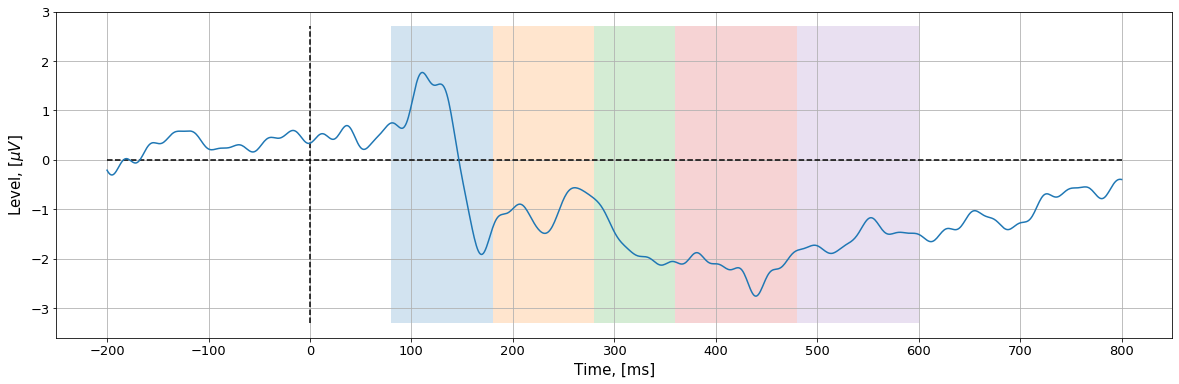

Files Loaded:  S01.edf.mrk S01.edf
Events number in record:  200
Columns Name:  RangeIndex(start=0, stop=200, step=1)



C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 121, using nperseg = 121
  warnings.warn('nperseg = {0:d} is greater than input length '




Files Loading:  S02.edf.mrk S02.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment_1\S02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 2357999  =      0.000 ...  2357.999 secs...

=== REJECT ===
Not setting metadata
2358 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2358 events and 1001 original time points ...
1 bad epochs dropped

=== ICA ===
Estimating rejection dictionary for eeg
rejection threshold:  {'eeg': 9.32913736599451e-05}
Fitting ICA to data using 49 channels (please be patient, this may take a while)


<ipython-input-7-efa77eb1992e>:5: RuntimeWarning: The following parameters passed to ICA.fit() will be ignored, as they only affect raw data (and it appears you passed epochs): reject
  ica.fit(epochs_ica, reject=reject_thr, tstep=1.0)


Selecting by explained variance: 24 components
Fitting ICA took 85.6s.

=== ARTIFACTS ===
Applying ICA to Raw instance
    Transforming to ICA space (24 components)
    Zeroing out 19 ICA components
    Projecting back using 49 PCA components

=== PLOT ===


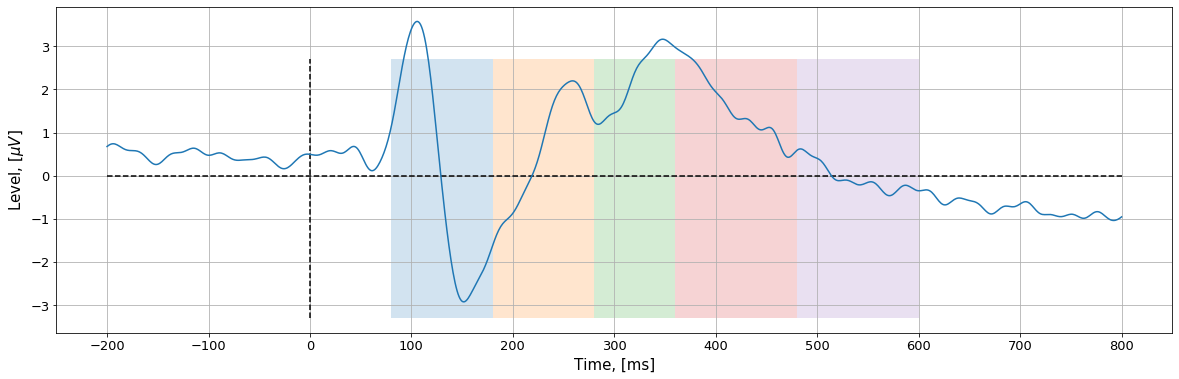

Files Loaded:  S02.edf.mrk S02.edf
Events number in record:  176
Columns Name:  RangeIndex(start=0, stop=176, step=1)



C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 121, using nperseg = 121
  warnings.warn('nperseg = {0:d} is greater than input length '




Files Loading:  S03.edf.mrk S03.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment_1\S03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 1855999  =      0.000 ...  1855.999 secs...

=== REJECT ===
Not setting metadata
1856 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1856 events and 1001 original time points ...
1 bad epochs dropped

=== ICA ===
Estimating rejection dictionary for eeg
rejection threshold:  {'eeg': 0.00017140894831625095}
Fitting ICA to data using 49 channels (please be patient, this may take a while)


<ipython-input-7-efa77eb1992e>:5: RuntimeWarning: The following parameters passed to ICA.fit() will be ignored, as they only affect raw data (and it appears you passed epochs): reject
  ica.fit(epochs_ica, reject=reject_thr, tstep=1.0)


Selecting by explained variance: 24 components
Fitting ICA took 106.4s.

=== ARTIFACTS ===
Applying ICA to Raw instance
    Transforming to ICA space (24 components)
    Zeroing out 19 ICA components
    Projecting back using 49 PCA components

=== PLOT ===


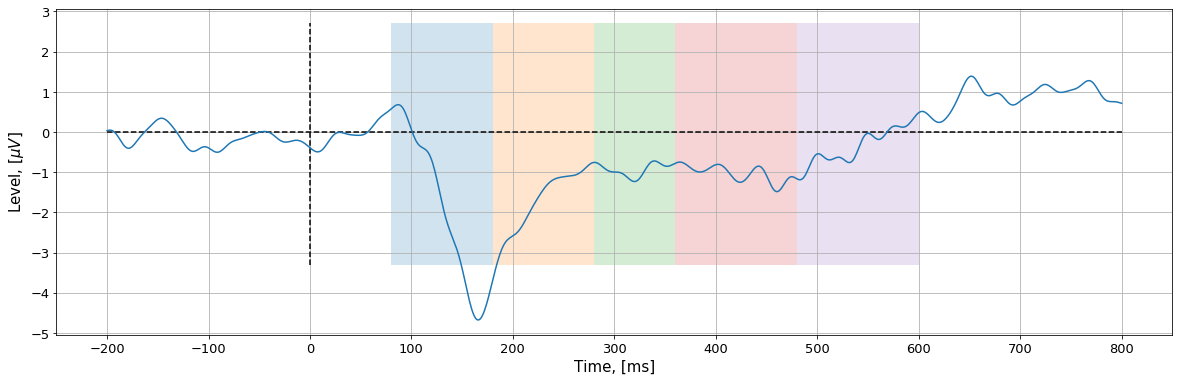

Files Loaded:  S03.edf.mrk S03.edf
Events number in record:  200
Columns Name:  RangeIndex(start=0, stop=200, step=1)



C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 121, using nperseg = 121
  warnings.warn('nperseg = {0:d} is greater than input length '




Files Loading:  S04.edf.mrk S04.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment_1\S04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 1829999  =      0.000 ...  1829.999 secs...

=== REJECT ===
Not setting metadata
1830 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1830 events and 1001 original time points ...
1 bad epochs dropped

=== ICA ===
Estimating rejection dictionary for eeg
rejection threshold:  {'eeg': 0.00010511894364382126}
Fitting ICA to data using 49 channels (please be patient, this may take a while)


<ipython-input-7-efa77eb1992e>:5: RuntimeWarning: The following parameters passed to ICA.fit() will be ignored, as they only affect raw data (and it appears you passed epochs): reject
  ica.fit(epochs_ica, reject=reject_thr, tstep=1.0)


Selecting by explained variance: 27 components
Fitting ICA took 230.3s.

=== ARTIFACTS ===
Applying ICA to Raw instance
    Transforming to ICA space (27 components)
    Zeroing out 25 ICA components
    Projecting back using 49 PCA components

=== PLOT ===


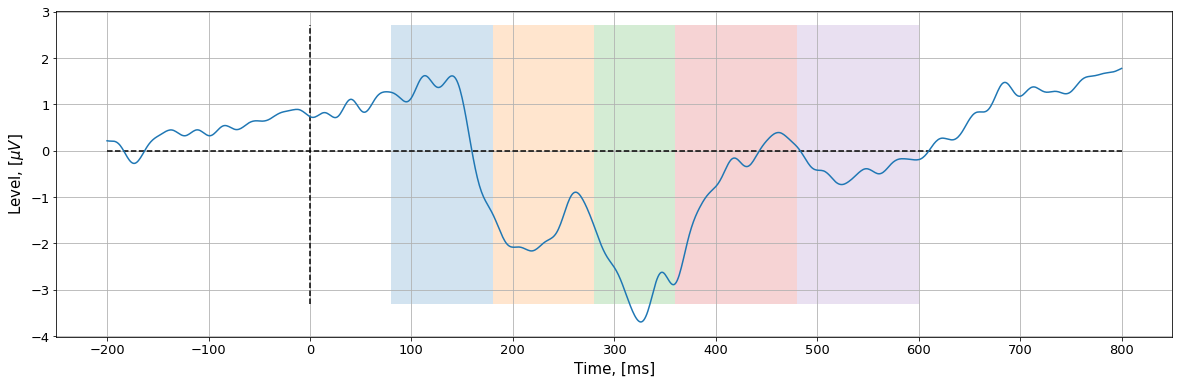

Files Loaded:  S04.edf.mrk S04.edf
Events number in record:  179
Columns Name:  RangeIndex(start=0, stop=179, step=1)



C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 121, using nperseg = 121
  warnings.warn('nperseg = {0:d} is greater than input length '




Files Loading:  S05.edf.mrk S05.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment_1\S05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 1981999  =      0.000 ...  1981.999 secs...

=== REJECT ===
Not setting metadata
1982 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1982 events and 1001 original time points ...
1 bad epochs dropped

=== ICA ===
Estimating rejection dictionary for eeg
rejection threshold:  {'eeg': 0.0001509770095727665}
Fitting ICA to data using 49 channels (please be patient, this may take a while)


<ipython-input-7-efa77eb1992e>:5: RuntimeWarning: The following parameters passed to ICA.fit() will be ignored, as they only affect raw data (and it appears you passed epochs): reject
  ica.fit(epochs_ica, reject=reject_thr, tstep=1.0)


Selecting by explained variance: 20 components
Fitting ICA took 96.3s.

=== ARTIFACTS ===
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 12 ICA components
    Projecting back using 49 PCA components

=== PLOT ===


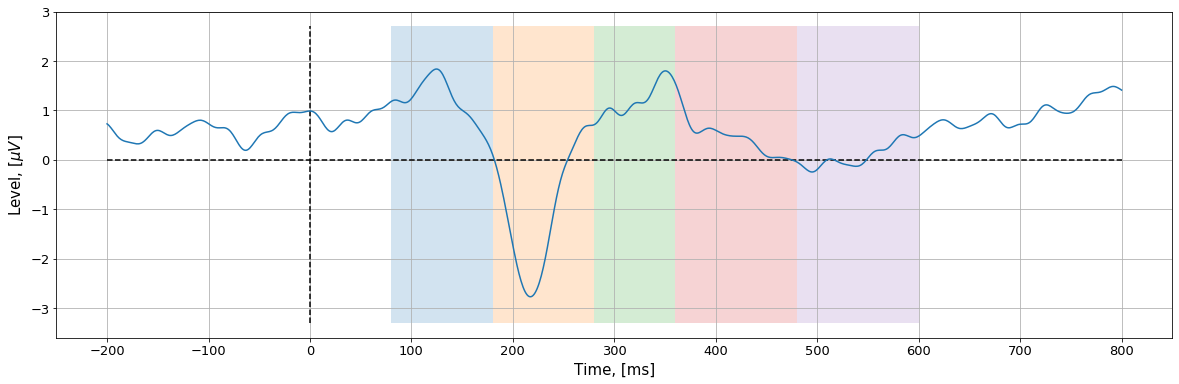

Files Loaded:  S05.edf.mrk S05.edf
Events number in record:  200
Columns Name:  RangeIndex(start=0, stop=200, step=1)



C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 121, using nperseg = 121
  warnings.warn('nperseg = {0:d} is greater than input length '




Files Loading:  S06.edf.mrk S06.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment_1\S06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 2379999  =      0.000 ...  2379.999 secs...

=== REJECT ===
Not setting metadata
2380 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2380 events and 1001 original time points ...
1 bad epochs dropped

=== ICA ===
Estimating rejection dictionary for eeg
rejection threshold:  {'eeg': 8.901259794412327e-05}
Fitting ICA to data using 49 channels (please be patient, this may take a while)


<ipython-input-7-efa77eb1992e>:5: RuntimeWarning: The following parameters passed to ICA.fit() will be ignored, as they only affect raw data (and it appears you passed epochs): reject
  ica.fit(epochs_ica, reject=reject_thr, tstep=1.0)


Selecting by explained variance: 21 components
Fitting ICA took 134.5s.

=== ARTIFACTS ===
Applying ICA to Raw instance
    Transforming to ICA space (21 components)
    Zeroing out 17 ICA components
    Projecting back using 49 PCA components

=== PLOT ===


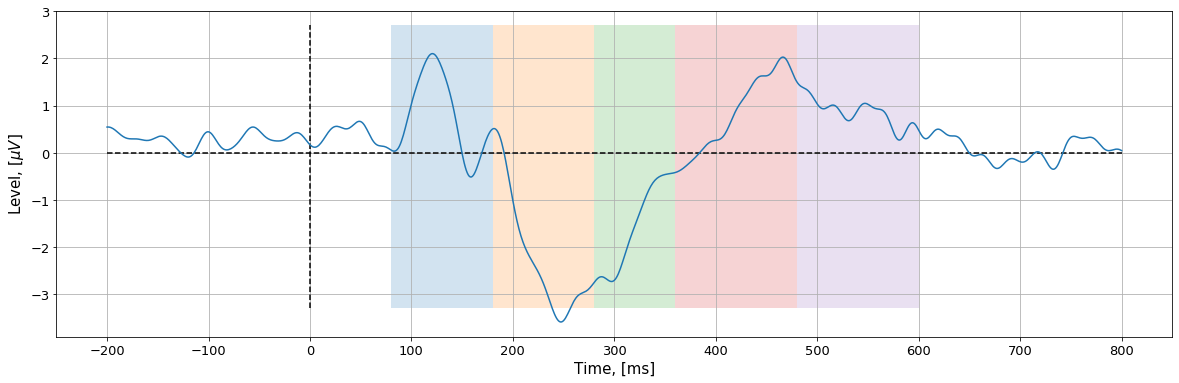

Files Loaded:  S06.edf.mrk S06.edf
Events number in record:  179
Columns Name:  RangeIndex(start=0, stop=179, step=1)



C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 121, using nperseg = 121
  warnings.warn('nperseg = {0:d} is greater than input length '




Files Loading:  S07.edf.mrk S07.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment_1\S07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 1994999  =      0.000 ...  1994.999 secs...

=== REJECT ===
Not setting metadata
1995 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1995 events and 1001 original time points ...
1 bad epochs dropped

=== ICA ===
Estimating rejection dictionary for eeg
rejection threshold:  {'eeg': 0.00010200942984394147}
Fitting ICA to data using 49 channels (please be patient, this may take a while)


<ipython-input-7-efa77eb1992e>:5: RuntimeWarning: The following parameters passed to ICA.fit() will be ignored, as they only affect raw data (and it appears you passed epochs): reject
  ica.fit(epochs_ica, reject=reject_thr, tstep=1.0)


Selecting by explained variance: 22 components
Fitting ICA took 98.6s.

=== ARTIFACTS ===
Applying ICA to Raw instance
    Transforming to ICA space (22 components)
    Zeroing out 14 ICA components
    Projecting back using 49 PCA components

=== PLOT ===


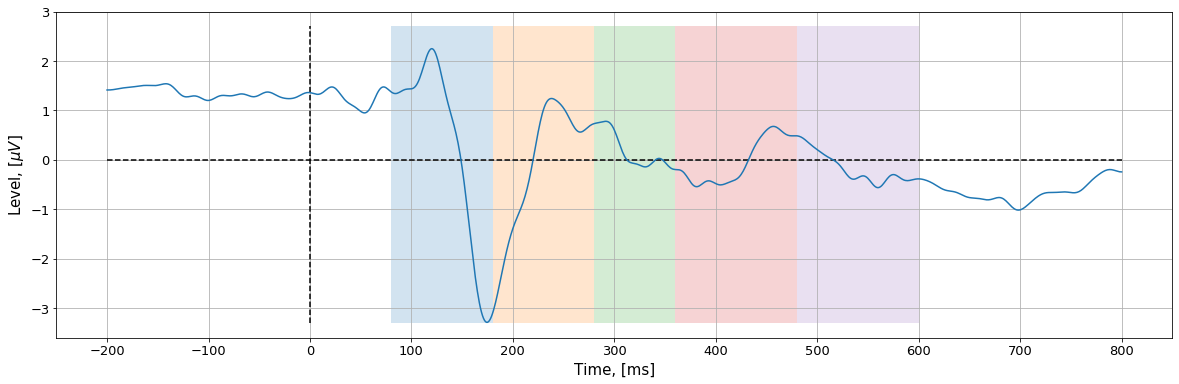

Files Loaded:  S07.edf.mrk S07.edf
Events number in record:  199
Columns Name:  RangeIndex(start=0, stop=199, step=1)



C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 121, using nperseg = 121
  warnings.warn('nperseg = {0:d} is greater than input length '




Files Loading:  S08.edf.mrk S08.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment_1\S08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 2145999  =      0.000 ...  2145.999 secs...

=== REJECT ===
Not setting metadata
2146 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2146 events and 1001 original time points ...
1 bad epochs dropped

=== ICA ===
Estimating rejection dictionary for eeg
rejection threshold:  {'eeg': 8.459747512964383e-05}
Fitting ICA to data using 49 channels (please be patient, this may take a while)


<ipython-input-7-efa77eb1992e>:5: RuntimeWarning: The following parameters passed to ICA.fit() will be ignored, as they only affect raw data (and it appears you passed epochs): reject
  ica.fit(epochs_ica, reject=reject_thr, tstep=1.0)


Selecting by explained variance: 27 components
Fitting ICA took 181.4s.

=== ARTIFACTS ===
Applying ICA to Raw instance
    Transforming to ICA space (27 components)
    Zeroing out 26 ICA components
    Projecting back using 49 PCA components

=== PLOT ===


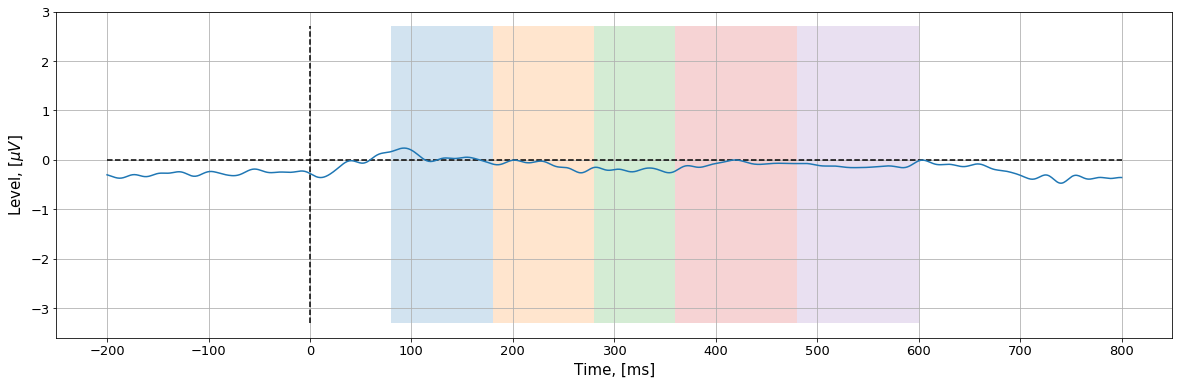

Files Loaded:  S08.edf.mrk S08.edf
Events number in record:  194
Columns Name:  RangeIndex(start=0, stop=194, step=1)



C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 121, using nperseg = 121
  warnings.warn('nperseg = {0:d} is greater than input length '




Files Loading:  S09.edf.mrk S09.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment_1\S09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 1850999  =      0.000 ...  1850.999 secs...

=== REJECT ===
Not setting metadata
1851 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1851 events and 1001 original time points ...
1 bad epochs dropped

=== ICA ===
Estimating rejection dictionary for eeg
rejection threshold:  {'eeg': 0.00026704397310250766}


<ipython-input-7-efa77eb1992e>:5: RuntimeWarning: The following parameters passed to ICA.fit() will be ignored, as they only affect raw data (and it appears you passed epochs): reject
  ica.fit(epochs_ica, reject=reject_thr, tstep=1.0)


Fitting ICA to data using 49 channels (please be patient, this may take a while)
Selecting by explained variance: 12 components
Fitting ICA took 42.5s.

=== ARTIFACTS ===
Applying ICA to Raw instance
    Transforming to ICA space (12 components)
    Zeroing out 8 ICA components
    Projecting back using 49 PCA components

=== PLOT ===


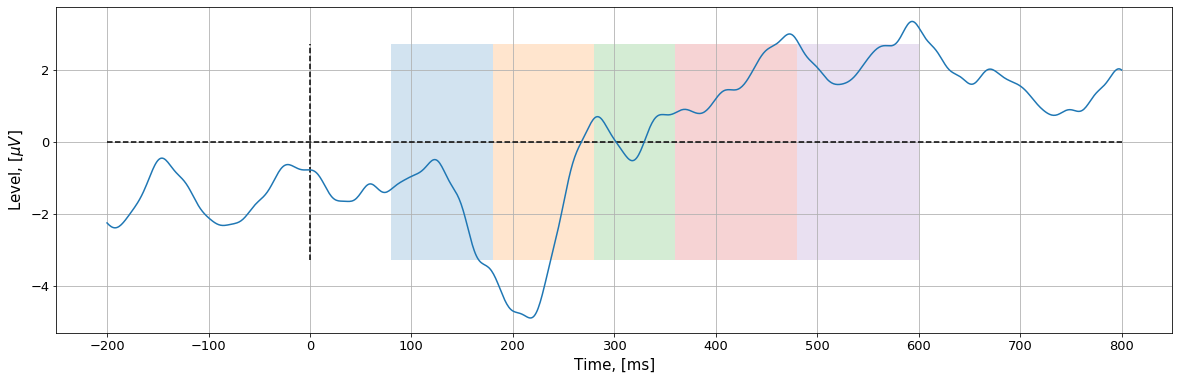

Files Loaded:  S09.edf.mrk S09.edf
Events number in record:  200
Columns Name:  RangeIndex(start=0, stop=200, step=1)



C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 121, using nperseg = 121
  warnings.warn('nperseg = {0:d} is greater than input length '




Files Loading:  S10.edf.mrk S10.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment_1\S10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 1924999  =      0.000 ...  1924.999 secs...

=== REJECT ===
Not setting metadata
1925 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1925 events and 1001 original time points ...
1 bad epochs dropped

=== ICA ===
Estimating rejection dictionary for eeg
rejection threshold:  {'eeg': 0.0001385526831399173}
Fitting ICA to data using 49 channels (please be patient, this may take a while)


<ipython-input-7-efa77eb1992e>:5: RuntimeWarning: The following parameters passed to ICA.fit() will be ignored, as they only affect raw data (and it appears you passed epochs): reject
  ica.fit(epochs_ica, reject=reject_thr, tstep=1.0)


Selecting by explained variance: 25 components
Fitting ICA took 145.9s.

=== ARTIFACTS ===
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 21 ICA components
    Projecting back using 49 PCA components

=== PLOT ===


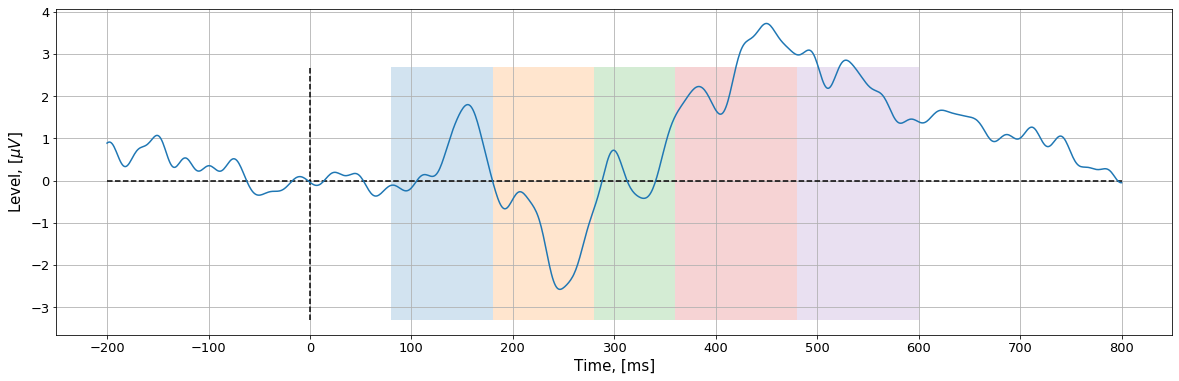

Files Loaded:  S10.edf.mrk S10.edf
Events number in record:  197
Columns Name:  RangeIndex(start=0, stop=197, step=1)



C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 121, using nperseg = 121
  warnings.warn('nperseg = {0:d} is greater than input length '




Files Loading:  S11.edf.mrk S11.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment_1\S11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 1715999  =      0.000 ...  1715.999 secs...

=== REJECT ===
Not setting metadata
1716 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1716 events and 1001 original time points ...
1 bad epochs dropped

=== ICA ===
Estimating rejection dictionary for eeg
rejection threshold:  {'eeg': 9.273839465940419e-05}
Fitting ICA to data using 49 channels (please be patient, this may take a while)


<ipython-input-7-efa77eb1992e>:5: RuntimeWarning: The following parameters passed to ICA.fit() will be ignored, as they only affect raw data (and it appears you passed epochs): reject
  ica.fit(epochs_ica, reject=reject_thr, tstep=1.0)


Selecting by explained variance: 25 components
Fitting ICA took 130.2s.

=== ARTIFACTS ===
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 17 ICA components
    Projecting back using 49 PCA components

=== PLOT ===


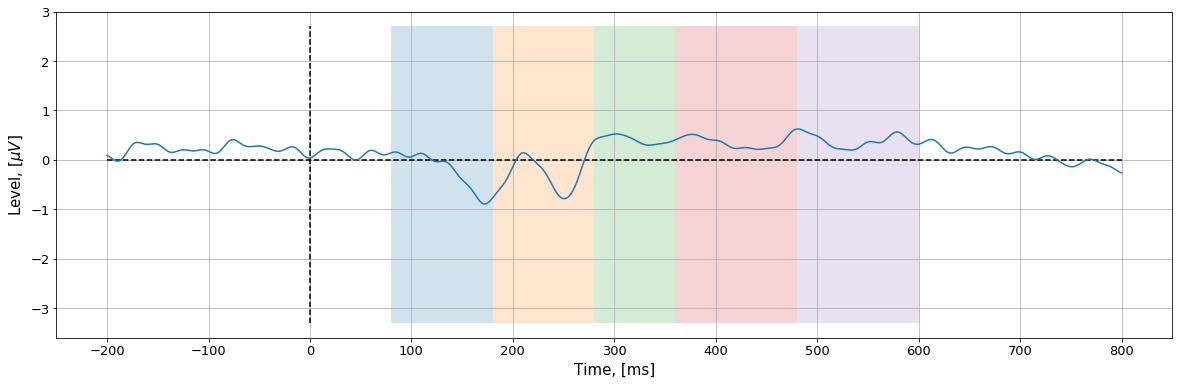

Files Loaded:  S11.edf.mrk S11.edf
Events number in record:  198
Columns Name:  RangeIndex(start=0, stop=198, step=1)



C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 121, using nperseg = 121
  warnings.warn('nperseg = {0:d} is greater than input length '




Files Loading:  S12.edf.mrk S12.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment_1\S12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 2035999  =      0.000 ...  2035.999 secs...

=== REJECT ===
Not setting metadata
2036 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2036 events and 1001 original time points ...
1 bad epochs dropped

=== ICA ===
Estimating rejection dictionary for eeg
rejection threshold:  {'eeg': 8.521157585836275e-05}
Fitting ICA to data using 49 channels (please be patient, this may take a while)


<ipython-input-7-efa77eb1992e>:5: RuntimeWarning: The following parameters passed to ICA.fit() will be ignored, as they only affect raw data (and it appears you passed epochs): reject
  ica.fit(epochs_ica, reject=reject_thr, tstep=1.0)


Selecting by explained variance: 22 components
Fitting ICA took 152.6s.

=== ARTIFACTS ===
Applying ICA to Raw instance
    Transforming to ICA space (22 components)
    Zeroing out 19 ICA components
    Projecting back using 49 PCA components

=== PLOT ===


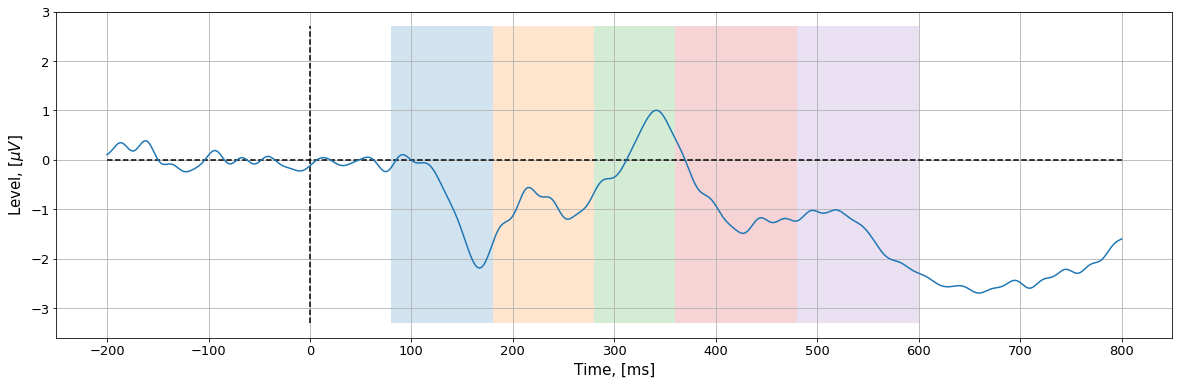

Files Loaded:  S12.edf.mrk S12.edf
Events number in record:  200
Columns Name:  RangeIndex(start=0, stop=200, step=1)



C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 121, using nperseg = 121
  warnings.warn('nperseg = {0:d} is greater than input length '




Files Loading:  S13.edf.mrk S13.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment_1\S13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 1924999  =      0.000 ...  1924.999 secs...

=== REJECT ===
Not setting metadata
1925 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1925 events and 1001 original time points ...
1 bad epochs dropped

=== ICA ===
Estimating rejection dictionary for eeg
rejection threshold:  {'eeg': 6.0862938424022254e-05}
Fitting ICA to data using 49 channels (please be patient, this may take a while)


<ipython-input-7-efa77eb1992e>:5: RuntimeWarning: The following parameters passed to ICA.fit() will be ignored, as they only affect raw data (and it appears you passed epochs): reject
  ica.fit(epochs_ica, reject=reject_thr, tstep=1.0)


Selecting by explained variance: 28 components
Fitting ICA took 128.3s.

=== ARTIFACTS ===
Applying ICA to Raw instance
    Transforming to ICA space (28 components)
    Zeroing out 21 ICA components
    Projecting back using 49 PCA components

=== PLOT ===


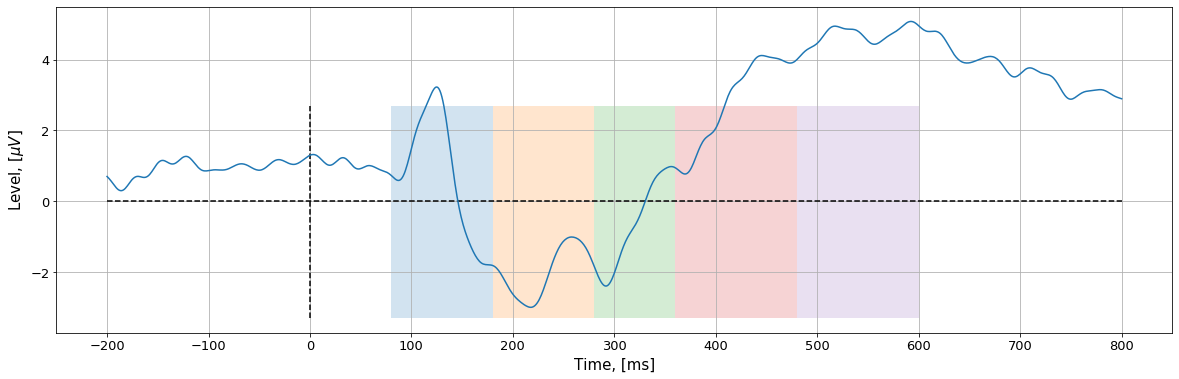

Files Loaded:  S13.edf.mrk S13.edf
Events number in record:  200
Columns Name:  RangeIndex(start=0, stop=200, step=1)



C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 121, using nperseg = 121
  warnings.warn('nperseg = {0:d} is greater than input length '




Files Loading:  S14.edf.mrk S14.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment_1\S14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 1928999  =      0.000 ...  1928.999 secs...

=== REJECT ===
Not setting metadata
1929 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1929 events and 1001 original time points ...
1 bad epochs dropped

=== ICA ===
Estimating rejection dictionary for eeg
rejection threshold:  {'eeg': 0.00011876845417517766}
Fitting ICA to data using 49 channels (please be patient, this may take a while)


<ipython-input-7-efa77eb1992e>:5: RuntimeWarning: The following parameters passed to ICA.fit() will be ignored, as they only affect raw data (and it appears you passed epochs): reject
  ica.fit(epochs_ica, reject=reject_thr, tstep=1.0)


Selecting by explained variance: 30 components
Fitting ICA took 160.7s.

=== ARTIFACTS ===
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 22 ICA components
    Projecting back using 49 PCA components

=== PLOT ===


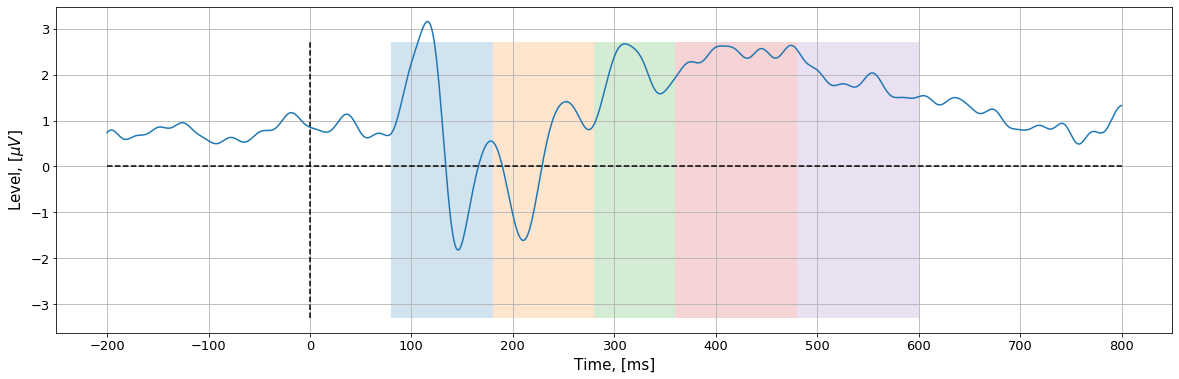

Files Loaded:  S14.edf.mrk S14.edf
Events number in record:  200
Columns Name:  RangeIndex(start=0, stop=200, step=1)



C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 121, using nperseg = 121
  warnings.warn('nperseg = {0:d} is greater than input length '




Files Loading:  S15.edf.mrk S15.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment_1\S15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 2104999  =      0.000 ...  2104.999 secs...

=== REJECT ===
Not setting metadata
2105 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2105 events and 1001 original time points ...
1 bad epochs dropped

=== ICA ===
Estimating rejection dictionary for eeg
rejection threshold:  {'eeg': 0.0003927596655520321}
Fitting ICA to data using 49 channels (please be patient, this may take a while)


<ipython-input-7-efa77eb1992e>:5: RuntimeWarning: The following parameters passed to ICA.fit() will be ignored, as they only affect raw data (and it appears you passed epochs): reject
  ica.fit(epochs_ica, reject=reject_thr, tstep=1.0)


Selecting by explained variance: 19 components
Fitting ICA took 105.7s.

=== ARTIFACTS ===
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 13 ICA components
    Projecting back using 49 PCA components

=== PLOT ===


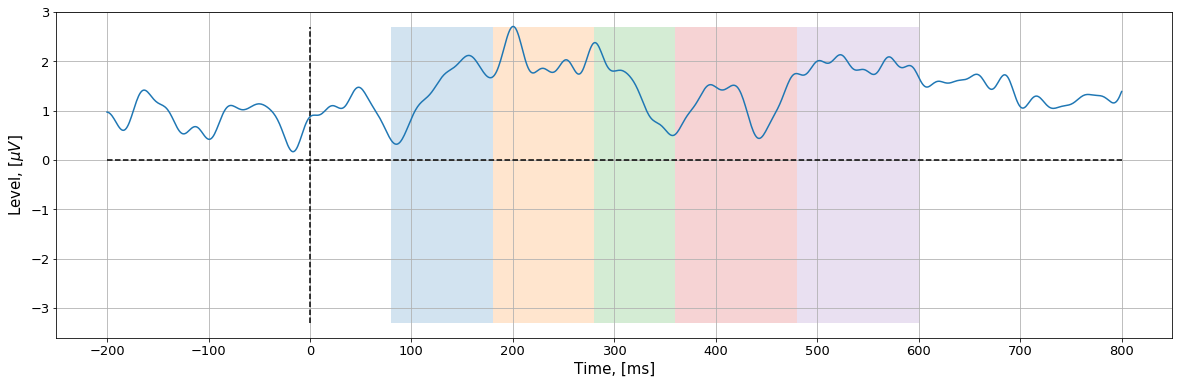

Files Loaded:  S15.edf.mrk S15.edf
Events number in record:  200
Columns Name:  RangeIndex(start=0, stop=200, step=1)



C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 121, using nperseg = 121
  warnings.warn('nperseg = {0:d} is greater than input length '




Files Loading:  S16.edf.mrk S16.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment_1\S16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 2002999  =      0.000 ...  2002.999 secs...

=== REJECT ===
Not setting metadata
2003 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2003 events and 1001 original time points ...
1 bad epochs dropped

=== ICA ===
Estimating rejection dictionary for eeg
rejection threshold:  {'eeg': 9.894386428877101e-05}
Fitting ICA to data using 49 channels (please be patient, this may take a while)


<ipython-input-7-efa77eb1992e>:5: RuntimeWarning: The following parameters passed to ICA.fit() will be ignored, as they only affect raw data (and it appears you passed epochs): reject
  ica.fit(epochs_ica, reject=reject_thr, tstep=1.0)


Selecting by explained variance: 27 components
Fitting ICA took 89.1s.

=== ARTIFACTS ===
Applying ICA to Raw instance
    Transforming to ICA space (27 components)
    Zeroing out 18 ICA components
    Projecting back using 49 PCA components

=== PLOT ===


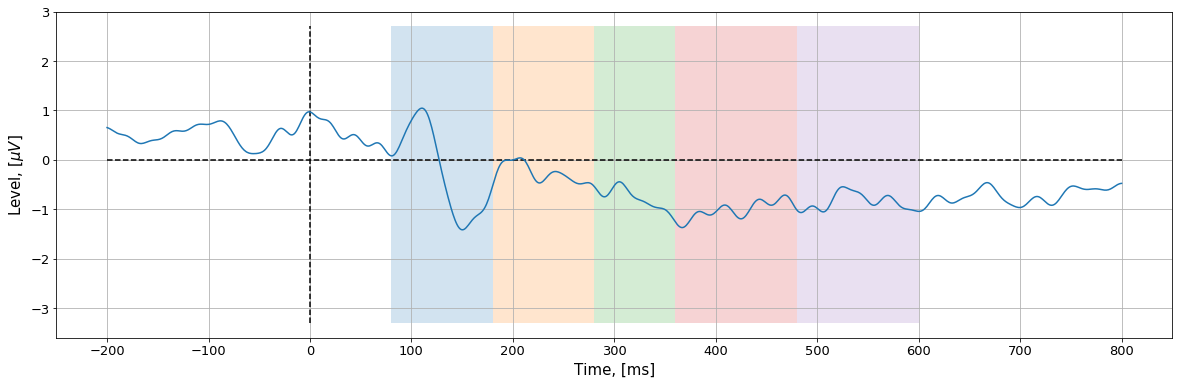

Files Loaded:  S16.edf.mrk S16.edf
Events number in record:  200
Columns Name:  RangeIndex(start=0, stop=200, step=1)



C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 121, using nperseg = 121
  warnings.warn('nperseg = {0:d} is greater than input length '




Files Loading:  S17.edf.mrk S17.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment_1\S17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 2215999  =      0.000 ...  2215.999 secs...

=== REJECT ===
Not setting metadata
2216 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2216 events and 1001 original time points ...
1 bad epochs dropped

=== ICA ===
Estimating rejection dictionary for eeg
rejection threshold:  {'eeg': 0.00014425604694005194}
Fitting ICA to data using 49 channels (please be patient, this may take a while)


<ipython-input-7-efa77eb1992e>:5: RuntimeWarning: The following parameters passed to ICA.fit() will be ignored, as they only affect raw data (and it appears you passed epochs): reject
  ica.fit(epochs_ica, reject=reject_thr, tstep=1.0)


Selecting by explained variance: 34 components
Fitting ICA took 289.8s.

=== ARTIFACTS ===
Applying ICA to Raw instance
    Transforming to ICA space (34 components)
    Zeroing out 27 ICA components
    Projecting back using 49 PCA components

=== PLOT ===


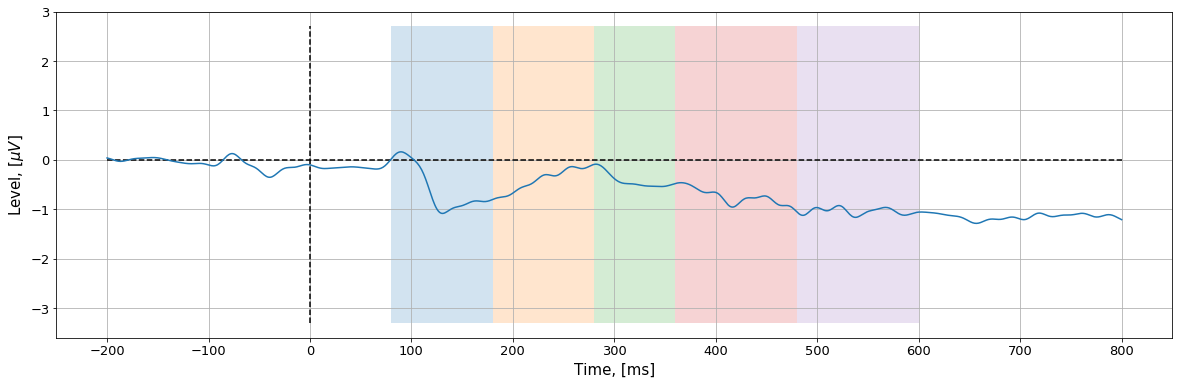

Files Loaded:  S17.edf.mrk S17.edf
Events number in record:  196
Columns Name:  RangeIndex(start=0, stop=196, step=1)



C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 121, using nperseg = 121
  warnings.warn('nperseg = {0:d} is greater than input length '




Files Loading:  S18.edf.mrk S18.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment_1\S18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 2109999  =      0.000 ...  2109.999 secs...

=== REJECT ===
Not setting metadata
2110 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2110 events and 1001 original time points ...
1 bad epochs dropped

=== ICA ===
Estimating rejection dictionary for eeg
rejection threshold:  {'eeg': 8.124358476712147e-05}
Fitting ICA to data using 49 channels (please be patient, this may take a while)


<ipython-input-7-efa77eb1992e>:5: RuntimeWarning: The following parameters passed to ICA.fit() will be ignored, as they only affect raw data (and it appears you passed epochs): reject
  ica.fit(epochs_ica, reject=reject_thr, tstep=1.0)


Selecting by explained variance: 21 components
Fitting ICA took 110.9s.

=== ARTIFACTS ===
Applying ICA to Raw instance
    Transforming to ICA space (21 components)
    Zeroing out 15 ICA components
    Projecting back using 49 PCA components

=== PLOT ===


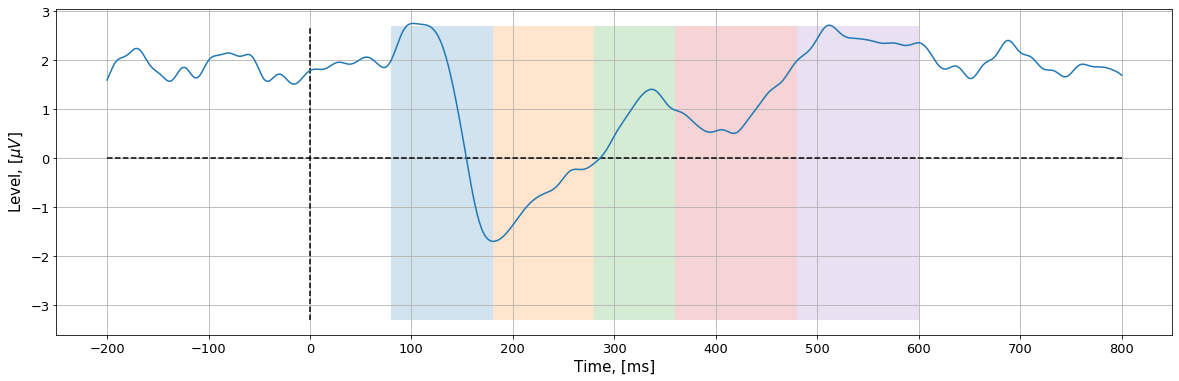

Files Loaded:  S18.edf.mrk S18.edf
Events number in record:  200
Columns Name:  RangeIndex(start=0, stop=200, step=1)



C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 121, using nperseg = 121
  warnings.warn('nperseg = {0:d} is greater than input length '




Files Loading:  S19.edf.mrk S19.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment_1\S19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 2095999  =      0.000 ...  2095.999 secs...

=== REJECT ===
Not setting metadata
2096 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2096 events and 1001 original time points ...
1 bad epochs dropped

=== ICA ===
Estimating rejection dictionary for eeg
rejection threshold:  {'eeg': 8.468181294521697e-05}
Fitting ICA to data using 49 channels (please be patient, this may take a while)


<ipython-input-7-efa77eb1992e>:5: RuntimeWarning: The following parameters passed to ICA.fit() will be ignored, as they only affect raw data (and it appears you passed epochs): reject
  ica.fit(epochs_ica, reject=reject_thr, tstep=1.0)


Selecting by explained variance: 15 components
Fitting ICA took 71.3s.

=== ARTIFACTS ===
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 11 ICA components
    Projecting back using 49 PCA components

=== PLOT ===


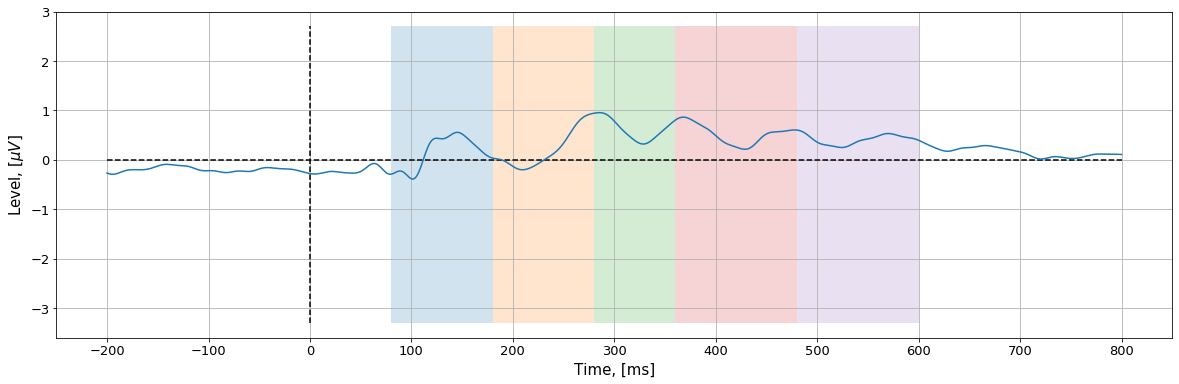

Files Loaded:  S19.edf.mrk S19.edf
Events number in record:  200
Columns Name:  RangeIndex(start=0, stop=200, step=1)



C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 121, using nperseg = 121
  warnings.warn('nperseg = {0:d} is greater than input length '




Files Loading:  S20.edf.mrk S20.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment_1\S20.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 2218999  =      0.000 ...  2218.999 secs...

=== REJECT ===
Not setting metadata
2219 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2219 events and 1001 original time points ...
1 bad epochs dropped

=== ICA ===
Estimating rejection dictionary for eeg
rejection threshold:  {'eeg': 9.01960962224733e-05}
Fitting ICA to data using 49 channels (please be patient, this may take a while)


<ipython-input-7-efa77eb1992e>:5: RuntimeWarning: The following parameters passed to ICA.fit() will be ignored, as they only affect raw data (and it appears you passed epochs): reject
  ica.fit(epochs_ica, reject=reject_thr, tstep=1.0)


Selecting by explained variance: 29 components
Fitting ICA took 168.9s.

=== ARTIFACTS ===
Applying ICA to Raw instance
    Transforming to ICA space (29 components)
    Zeroing out 23 ICA components
    Projecting back using 49 PCA components

=== PLOT ===


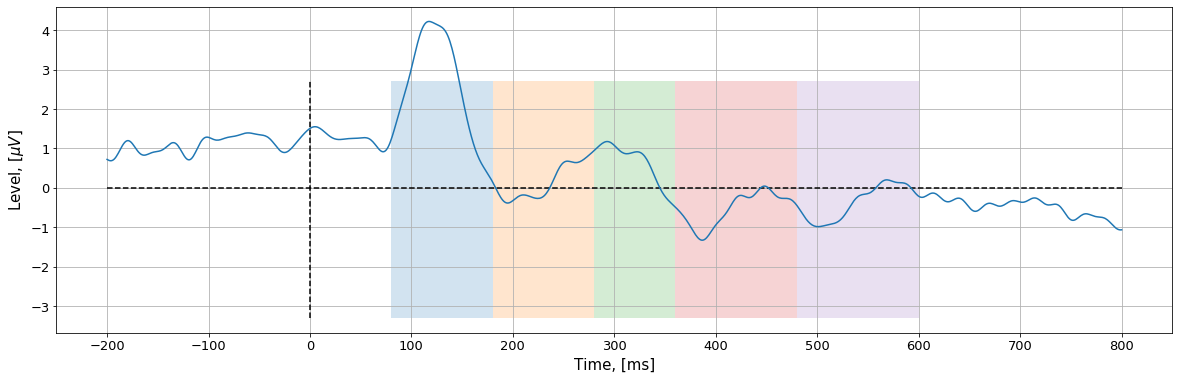

Files Loaded:  S20.edf.mrk S20.edf
Events number in record:  194
Columns Name:  RangeIndex(start=0, stop=194, step=1)



C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 121, using nperseg = 121
  warnings.warn('nperseg = {0:d} is greater than input length '


In [51]:
peaks_features_ERN,  peaks_features_P200, peaks_features_FRN, peaks_features_P300, peaks_features_N500, \
  dwt_features_ERN,    dwt_features_P200,   dwt_features_FRN,   dwt_features_P300,   dwt_features_N500, \
  cwt_features_ERN,    cwt_features_P200,   cwt_features_FRN,   cwt_features_P300,   cwt_features_N500, \
  peaks_features_1000ms, \
  dwt_features_1000ms, \
  cwt_features_1000ms, \
  y = get_signal_features(data_dir = './', 
                          cwt_waveletname = 'morl', 
                          dwt_waveletname = 'db4', 
                          denominator = 10, 
                          percentile = 5, 
                          n_peaks = 50)

In [20]:
np.array(dwt_features_1000ms).shape

(3912, 264)

In [21]:
np.array(dwt_features_ERN).shape, np.array(dwt_features_P200).shape, np.array(dwt_features_FRN).shape, np.array(dwt_features_P300).shape, np.array(dwt_features_N500).shape

((3912, 132), (3912, 132), (3912, 132), (3912, 165), (3912, 165))

In [22]:
np.array(cwt_features_1000ms).shape

(3912, 128, 1001)

In [23]:
np.array(cwt_features_ERN).shape, np.array(cwt_features_P200).shape, np.array(cwt_features_FRN).shape, np.array(cwt_features_P300).shape, np.array(cwt_features_N500).shape

((3912, 128, 101),
 (3912, 128, 101),
 (3912, 128, 81),
 (3912, 128, 121),
 (3912, 128, 121))

In [24]:
np.array(peaks_features_1000ms).shape

(3912, 300)

In [25]:
np.array(peaks_features_ERN).shape, np.array(peaks_features_P200).shape, np.array(peaks_features_FRN).shape, np.array(peaks_features_P300).shape, np.array(peaks_features_N500).shape

((3912, 300), (3912, 300), (3912, 300), (3912, 300), (3912, 300))

In [55]:
np.array(y).shape, np.unique(y)

((3912,), array([0, 1]))

In [27]:
def plot_total_dataset(file_igt, file_eeg):
    print('')
    print('')
    print('Files Loading: ', file_igt, file_eeg)
    igt = pd.read_csv(file_igt)                  # reading IGT data
    
    events = EVENTS(igt)                         # trigger-events file creation

    file_raw = mne.io.read_raw_edf(file_eeg)     # reading EEG data
        
    raw = DROP_CHANNELS_IO(file_raw)
    eeg = DIGITIZING_IO(raw)
    
    print('')
    print('=== FILTER ===')
    file_eeg_filt = FILTER_40(eeg)              # EEG filtering
    print('')
    print('=== REJECT ===')  
    file_eeg_filt_ica = FILTER_ICA(eeg)         # EEG ICA filter
    file_eeg_filt_reject = REJECT(file_eeg_filt_ica)
    print('')
    print('=== ICA ===')
    file_eeg_filt_reject_ica = ICA_REJECT_99(file_eeg_filt_reject)
    print('')
    print('=== ARTIFACTS ===')
    file_eeg_filt_reject_ica_clean = ARTIFACTS_REMOVING_IO(file_eeg_filt_reject_ica, file_eeg_filt)
    print('')
    print('=== PLOT ===')
    file_eeg_filt_reject_ica_clean_frame = FRAME(file_eeg_filt_reject_ica_clean)
    EEGdata = EEG(file_eeg_filt_reject_ica_clean_frame, events) 
    EEGdata_avg = TOTAL(EEGdata)
    
  
    return EEGdata_avg

In [28]:
EEGdata_avg01 = plot_total_dataset('S01.edf.mrk', 'S01.edf')
EEGdata_avg02 = plot_total_dataset('S02.edf.mrk', 'S02.edf')
EEGdata_avg03 = plot_total_dataset('S03.edf.mrk', 'S03.edf')
EEGdata_avg04 = plot_total_dataset('S04.edf.mrk', 'S04.edf')
EEGdata_avg05 = plot_total_dataset('S05.edf.mrk', 'S05.edf')
EEGdata_avg06 = plot_total_dataset('S06.edf.mrk', 'S06.edf')
EEGdata_avg07 = plot_total_dataset('S07.edf.mrk', 'S07.edf')
EEGdata_avg08 = plot_total_dataset('S08.edf.mrk', 'S08.edf')
EEGdata_avg09 = plot_total_dataset('S09.edf.mrk', 'S09.edf')
EEGdata_avg10 = plot_total_dataset('S10.edf.mrk', 'S10.edf')
EEGdata_avg11 = plot_total_dataset('S11.edf.mrk', 'S11.edf')
EEGdata_avg12 = plot_total_dataset('S12.edf.mrk', 'S12.edf')
EEGdata_avg13 = plot_total_dataset('S13.edf.mrk', 'S13.edf')
EEGdata_avg14 = plot_total_dataset('S14.edf.mrk', 'S14.edf')
EEGdata_avg15 = plot_total_dataset('S15.edf.mrk', 'S15.edf')
EEGdata_avg16 = plot_total_dataset('S16.edf.mrk', 'S16.edf')
EEGdata_avg17 = plot_total_dataset('S17.edf.mrk', 'S17.edf')
EEGdata_avg18 = plot_total_dataset('S18.edf.mrk', 'S18.edf')
EEGdata_avg19 = plot_total_dataset('S19.edf.mrk', 'S19.edf')
EEGdata_avg20 = plot_total_dataset('S20.edf.mrk', 'S20.edf')



Files Loading:  S01.edf.mrk S01.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment_1\S01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 1843999  =      0.000 ...  1843.999 secs...

=== REJECT ===
Not setting metadata
1844 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1844 events and 1001 original time points ...
1 bad epochs dropped

=== ICA ===
Estimating rejection dictionary for eeg
rejection threshold:  {'eeg': 5.978773516675648e-05}
Fitting ICA to data using 49 channels (please be patient, this may take a while)


<ipython-input-7-efa77eb1992e>:5: RuntimeWarning: The following parameters passed to ICA.fit() will be ignored, as they only affect raw data (and it appears you passed epochs): reject
  ica.fit(epochs_ica, reject=reject_thr, tstep=1.0)


Selecting by explained variance: 26 components
Fitting ICA took 131.1s.

=== ARTIFACTS ===
Applying ICA to Raw instance
    Transforming to ICA space (26 components)
    Zeroing out 18 ICA components
    Projecting back using 49 PCA components

=== PLOT ===


Files Loading:  S02.edf.mrk S02.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment_1\S02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 2357999  =      0.000 ...  2357.999 secs...

=== REJECT ===
Not setting metadata
2358 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2358 events and 1001 original time points ...
1 bad epochs dropped

=== ICA ===
Estimating rejection dictionary for eeg
rejection threshold:  {'eeg': 9.32913736599451e-05}
Fitting ICA to data using 49 channels (please be patient, this may take a while)


<ipython-input-7-efa77eb1992e>:5: RuntimeWarning: The following parameters passed to ICA.fit() will be ignored, as they only affect raw data (and it appears you passed epochs): reject
  ica.fit(epochs_ica, reject=reject_thr, tstep=1.0)


Selecting by explained variance: 24 components
Fitting ICA took 78.6s.

=== ARTIFACTS ===
Applying ICA to Raw instance
    Transforming to ICA space (24 components)
    Zeroing out 19 ICA components
    Projecting back using 49 PCA components

=== PLOT ===


Files Loading:  S03.edf.mrk S03.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment_1\S03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 1855999  =      0.000 ...  1855.999 secs...

=== REJECT ===
Not setting metadata
1856 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1856 events and 1001 original time points ...
1 bad epochs dropped

=== ICA ===
Estimating rejection dictionary for eeg
rejection threshold:  {'eeg': 0.00017140894831625095}
Fitting ICA to data using 49 channels (please be patient, this may take a while)


<ipython-input-7-efa77eb1992e>:5: RuntimeWarning: The following parameters passed to ICA.fit() will be ignored, as they only affect raw data (and it appears you passed epochs): reject
  ica.fit(epochs_ica, reject=reject_thr, tstep=1.0)


Selecting by explained variance: 24 components
Fitting ICA took 94.5s.

=== ARTIFACTS ===
Applying ICA to Raw instance
    Transforming to ICA space (24 components)
    Zeroing out 19 ICA components
    Projecting back using 49 PCA components

=== PLOT ===


Files Loading:  S04.edf.mrk S04.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment_1\S04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 1829999  =      0.000 ...  1829.999 secs...

=== REJECT ===
Not setting metadata
1830 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1830 events and 1001 original time points ...
1 bad epochs dropped

=== ICA ===
Estimating rejection dictionary for eeg
rejection threshold:  {'eeg': 0.00010511894364382126}
Fitting ICA to data using 49 channels (please be patient, this may take a while)


<ipython-input-7-efa77eb1992e>:5: RuntimeWarning: The following parameters passed to ICA.fit() will be ignored, as they only affect raw data (and it appears you passed epochs): reject
  ica.fit(epochs_ica, reject=reject_thr, tstep=1.0)


Selecting by explained variance: 27 components
Fitting ICA took 162.5s.

=== ARTIFACTS ===
Applying ICA to Raw instance
    Transforming to ICA space (27 components)
    Zeroing out 25 ICA components
    Projecting back using 49 PCA components

=== PLOT ===


Files Loading:  S05.edf.mrk S05.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment_1\S05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 1981999  =      0.000 ...  1981.999 secs...

=== REJECT ===
Not setting metadata
1982 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1982 events and 1001 original time points ...
1 bad epochs dropped

=== ICA ===
Estimating rejection dictionary for eeg
rejection threshold:  {'eeg': 0.0001509770095727665}
Fitting ICA to data using 49 channels (please be patient, this may take a while)


<ipython-input-7-efa77eb1992e>:5: RuntimeWarning: The following parameters passed to ICA.fit() will be ignored, as they only affect raw data (and it appears you passed epochs): reject
  ica.fit(epochs_ica, reject=reject_thr, tstep=1.0)


Selecting by explained variance: 20 components
Fitting ICA took 67.9s.

=== ARTIFACTS ===
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 12 ICA components
    Projecting back using 49 PCA components

=== PLOT ===


Files Loading:  S06.edf.mrk S06.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment_1\S06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 2379999  =      0.000 ...  2379.999 secs...

=== REJECT ===
Not setting metadata
2380 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2380 events and 1001 original time points ...
1 bad epochs dropped

=== ICA ===
Estimating rejection dictionary for eeg
rejection threshold:  {'eeg': 8.901259794412327e-05}
Fitting ICA to data using 49 channels (please be patient, this may take a while)


<ipython-input-7-efa77eb1992e>:5: RuntimeWarning: The following parameters passed to ICA.fit() will be ignored, as they only affect raw data (and it appears you passed epochs): reject
  ica.fit(epochs_ica, reject=reject_thr, tstep=1.0)


Selecting by explained variance: 21 components
Fitting ICA took 105.4s.

=== ARTIFACTS ===
Applying ICA to Raw instance
    Transforming to ICA space (21 components)
    Zeroing out 17 ICA components
    Projecting back using 49 PCA components

=== PLOT ===


Files Loading:  S07.edf.mrk S07.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment_1\S07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 1994999  =      0.000 ...  1994.999 secs...

=== REJECT ===
Not setting metadata
1995 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1995 events and 1001 original time points ...
1 bad epochs dropped

=== ICA ===
Estimating rejection dictionary for eeg
rejection threshold:  {'eeg': 0.00010200942984394147}
Fitting ICA to data using 49 channels (please be patient, this may take a while)


<ipython-input-7-efa77eb1992e>:5: RuntimeWarning: The following parameters passed to ICA.fit() will be ignored, as they only affect raw data (and it appears you passed epochs): reject
  ica.fit(epochs_ica, reject=reject_thr, tstep=1.0)


Selecting by explained variance: 22 components
Fitting ICA took 69.8s.

=== ARTIFACTS ===
Applying ICA to Raw instance
    Transforming to ICA space (22 components)
    Zeroing out 14 ICA components
    Projecting back using 49 PCA components

=== PLOT ===


Files Loading:  S08.edf.mrk S08.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment_1\S08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 2145999  =      0.000 ...  2145.999 secs...

=== REJECT ===
Not setting metadata
2146 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2146 events and 1001 original time points ...
1 bad epochs dropped

=== ICA ===
Estimating rejection dictionary for eeg
rejection threshold:  {'eeg': 8.459747512964383e-05}
Fitting ICA to data using 49 channels (please be patient, this may take a while)


<ipython-input-7-efa77eb1992e>:5: RuntimeWarning: The following parameters passed to ICA.fit() will be ignored, as they only affect raw data (and it appears you passed epochs): reject
  ica.fit(epochs_ica, reject=reject_thr, tstep=1.0)


Selecting by explained variance: 27 components
Fitting ICA took 150.4s.

=== ARTIFACTS ===
Applying ICA to Raw instance
    Transforming to ICA space (27 components)
    Zeroing out 26 ICA components
    Projecting back using 49 PCA components

=== PLOT ===


Files Loading:  S09.edf.mrk S09.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment_1\S09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 1850999  =      0.000 ...  1850.999 secs...

=== REJECT ===
Not setting metadata
1851 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1851 events and 1001 original time points ...
1 bad epochs dropped

=== ICA ===
Estimating rejection dictionary for eeg
rejection threshold:  {'eeg': 0.00026704397310250766}
Fitting ICA to data using 49 channels (please be patient, this may take a while)


<ipython-input-7-efa77eb1992e>:5: RuntimeWarning: The following parameters passed to ICA.fit() will be ignored, as they only affect raw data (and it appears you passed epochs): reject
  ica.fit(epochs_ica, reject=reject_thr, tstep=1.0)


Selecting by explained variance: 12 components
Fitting ICA took 37.5s.

=== ARTIFACTS ===
Applying ICA to Raw instance
    Transforming to ICA space (12 components)
    Zeroing out 8 ICA components
    Projecting back using 49 PCA components

=== PLOT ===


Files Loading:  S10.edf.mrk S10.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment_1\S10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 1924999  =      0.000 ...  1924.999 secs...

=== REJECT ===
Not setting metadata
1925 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1925 events and 1001 original time points ...
1 bad epochs dropped

=== ICA ===
Estimating rejection dictionary for eeg
rejection threshold:  {'eeg': 0.0001385526831399173}
Fitting ICA to data using 49 channels (please be patient, this may take a while)


<ipython-input-7-efa77eb1992e>:5: RuntimeWarning: The following parameters passed to ICA.fit() will be ignored, as they only affect raw data (and it appears you passed epochs): reject
  ica.fit(epochs_ica, reject=reject_thr, tstep=1.0)


Selecting by explained variance: 25 components
Fitting ICA took 123.9s.

=== ARTIFACTS ===
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 21 ICA components
    Projecting back using 49 PCA components

=== PLOT ===


Files Loading:  S11.edf.mrk S11.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment_1\S11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 1715999  =      0.000 ...  1715.999 secs...

=== REJECT ===
Not setting metadata
1716 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1716 events and 1001 original time points ...
1 bad epochs dropped

=== ICA ===
Estimating rejection dictionary for eeg
rejection threshold:  {'eeg': 9.273839465940419e-05}
Fitting ICA to data using 49 channels (please be patient, this may take a while)


<ipython-input-7-efa77eb1992e>:5: RuntimeWarning: The following parameters passed to ICA.fit() will be ignored, as they only affect raw data (and it appears you passed epochs): reject
  ica.fit(epochs_ica, reject=reject_thr, tstep=1.0)


Selecting by explained variance: 25 components
Fitting ICA took 108.2s.

=== ARTIFACTS ===
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 17 ICA components
    Projecting back using 49 PCA components

=== PLOT ===


Files Loading:  S12.edf.mrk S12.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment_1\S12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 2035999  =      0.000 ...  2035.999 secs...

=== REJECT ===
Not setting metadata
2036 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2036 events and 1001 original time points ...
1 bad epochs dropped

=== ICA ===
Estimating rejection dictionary for eeg
rejection threshold:  {'eeg': 8.521157585836275e-05}
Fitting ICA to data using 49 channels (please be patient, this may take a while)


<ipython-input-7-efa77eb1992e>:5: RuntimeWarning: The following parameters passed to ICA.fit() will be ignored, as they only affect raw data (and it appears you passed epochs): reject
  ica.fit(epochs_ica, reject=reject_thr, tstep=1.0)


Selecting by explained variance: 22 components
Fitting ICA took 146.9s.

=== ARTIFACTS ===
Applying ICA to Raw instance
    Transforming to ICA space (22 components)
    Zeroing out 19 ICA components
    Projecting back using 49 PCA components

=== PLOT ===


Files Loading:  S13.edf.mrk S13.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment_1\S13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 1924999  =      0.000 ...  1924.999 secs...

=== REJECT ===
Not setting metadata
1925 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1925 events and 1001 original time points ...
1 bad epochs dropped

=== ICA ===
Estimating rejection dictionary for eeg
rejection threshold:  {'eeg': 6.0862938424022254e-05}
Fitting ICA to data using 49 channels (please be patient, this may take a while)


<ipython-input-7-efa77eb1992e>:5: RuntimeWarning: The following parameters passed to ICA.fit() will be ignored, as they only affect raw data (and it appears you passed epochs): reject
  ica.fit(epochs_ica, reject=reject_thr, tstep=1.0)


Selecting by explained variance: 28 components
Fitting ICA took 116.7s.

=== ARTIFACTS ===
Applying ICA to Raw instance
    Transforming to ICA space (28 components)
    Zeroing out 21 ICA components
    Projecting back using 49 PCA components

=== PLOT ===


Files Loading:  S14.edf.mrk S14.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment_1\S14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 1928999  =      0.000 ...  1928.999 secs...

=== REJECT ===
Not setting metadata
1929 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1929 events and 1001 original time points ...
1 bad epochs dropped

=== ICA ===
Estimating rejection dictionary for eeg
rejection threshold:  {'eeg': 0.00011876845417517766}
Fitting ICA to data using 49 channels (please be patient, this may take a while)


<ipython-input-7-efa77eb1992e>:5: RuntimeWarning: The following parameters passed to ICA.fit() will be ignored, as they only affect raw data (and it appears you passed epochs): reject
  ica.fit(epochs_ica, reject=reject_thr, tstep=1.0)


Selecting by explained variance: 30 components
Fitting ICA took 149.6s.

=== ARTIFACTS ===
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 22 ICA components
    Projecting back using 49 PCA components

=== PLOT ===


Files Loading:  S15.edf.mrk S15.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment_1\S15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 2104999  =      0.000 ...  2104.999 secs...

=== REJECT ===
Not setting metadata
2105 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2105 events and 1001 original time points ...
1 bad epochs dropped

=== ICA ===
Estimating rejection dictionary for eeg
rejection threshold:  {'eeg': 0.0003927596655520321}
Fitting ICA to data using 49 channels (please be patient, this may take a while)


<ipython-input-7-efa77eb1992e>:5: RuntimeWarning: The following parameters passed to ICA.fit() will be ignored, as they only affect raw data (and it appears you passed epochs): reject
  ica.fit(epochs_ica, reject=reject_thr, tstep=1.0)


Selecting by explained variance: 19 components
Fitting ICA took 98.0s.

=== ARTIFACTS ===
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 13 ICA components
    Projecting back using 49 PCA components

=== PLOT ===


Files Loading:  S16.edf.mrk S16.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment_1\S16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 2002999  =      0.000 ...  2002.999 secs...

=== REJECT ===
Not setting metadata
2003 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2003 events and 1001 original time points ...
1 bad epochs dropped

=== ICA ===
Estimating rejection dictionary for eeg
rejection threshold:  {'eeg': 9.894386428877101e-05}
Fitting ICA to data using 49 channels (please be patient, this may take a while)


<ipython-input-7-efa77eb1992e>:5: RuntimeWarning: The following parameters passed to ICA.fit() will be ignored, as they only affect raw data (and it appears you passed epochs): reject
  ica.fit(epochs_ica, reject=reject_thr, tstep=1.0)


Selecting by explained variance: 27 components
Fitting ICA took 76.0s.

=== ARTIFACTS ===
Applying ICA to Raw instance
    Transforming to ICA space (27 components)
    Zeroing out 18 ICA components
    Projecting back using 49 PCA components

=== PLOT ===


Files Loading:  S17.edf.mrk S17.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment_1\S17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 2215999  =      0.000 ...  2215.999 secs...

=== REJECT ===
Not setting metadata
2216 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2216 events and 1001 original time points ...
1 bad epochs dropped

=== ICA ===
Estimating rejection dictionary for eeg
rejection threshold:  {'eeg': 0.00014425604694005194}
Fitting ICA to data using 49 channels (please be patient, this may take a while)


<ipython-input-7-efa77eb1992e>:5: RuntimeWarning: The following parameters passed to ICA.fit() will be ignored, as they only affect raw data (and it appears you passed epochs): reject
  ica.fit(epochs_ica, reject=reject_thr, tstep=1.0)


Selecting by explained variance: 34 components
Fitting ICA took 249.1s.

=== ARTIFACTS ===
Applying ICA to Raw instance
    Transforming to ICA space (34 components)
    Zeroing out 27 ICA components
    Projecting back using 49 PCA components

=== PLOT ===


Files Loading:  S18.edf.mrk S18.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment_1\S18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 2109999  =      0.000 ...  2109.999 secs...

=== REJECT ===
Not setting metadata
2110 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2110 events and 1001 original time points ...
1 bad epochs dropped

=== ICA ===
Estimating rejection dictionary for eeg
rejection threshold:  {'eeg': 8.124358476712147e-05}
Fitting ICA to data using 49 channels (please be patient, this may take a while)


<ipython-input-7-efa77eb1992e>:5: RuntimeWarning: The following parameters passed to ICA.fit() will be ignored, as they only affect raw data (and it appears you passed epochs): reject
  ica.fit(epochs_ica, reject=reject_thr, tstep=1.0)


Selecting by explained variance: 21 components
Fitting ICA took 88.8s.

=== ARTIFACTS ===
Applying ICA to Raw instance
    Transforming to ICA space (21 components)
    Zeroing out 15 ICA components
    Projecting back using 49 PCA components

=== PLOT ===


Files Loading:  S19.edf.mrk S19.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment_1\S19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 2095999  =      0.000 ...  2095.999 secs...

=== REJECT ===
Not setting metadata
2096 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2096 events and 1001 original time points ...
1 bad epochs dropped

=== ICA ===
Estimating rejection dictionary for eeg
rejection threshold:  {'eeg': 8.468181294521697e-05}
Fitting ICA to data using 49 channels (please be patient, this may take a while)


<ipython-input-7-efa77eb1992e>:5: RuntimeWarning: The following parameters passed to ICA.fit() will be ignored, as they only affect raw data (and it appears you passed epochs): reject
  ica.fit(epochs_ica, reject=reject_thr, tstep=1.0)


Selecting by explained variance: 15 components
Fitting ICA took 61.8s.

=== ARTIFACTS ===
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 11 ICA components
    Projecting back using 49 PCA components

=== PLOT ===


Files Loading:  S20.edf.mrk S20.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment_1\S20.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 2218999  =      0.000 ...  2218.999 secs...

=== REJECT ===
Not setting metadata
2219 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2219 events and 1001 original time points ...
1 bad epochs dropped

=== ICA ===
Estimating rejection dictionary for eeg
rejection threshold:  {'eeg': 9.01960962224733e-05}
Fitting ICA to data using 49 channels (please be patient, this may take a while)


<ipython-input-7-efa77eb1992e>:5: RuntimeWarning: The following parameters passed to ICA.fit() will be ignored, as they only affect raw data (and it appears you passed epochs): reject
  ica.fit(epochs_ica, reject=reject_thr, tstep=1.0)


Selecting by explained variance: 29 components
Fitting ICA took 150.1s.

=== ARTIFACTS ===
Applying ICA to Raw instance
    Transforming to ICA space (29 components)
    Zeroing out 23 ICA components
    Projecting back using 49 PCA components

=== PLOT ===


In [29]:
EEGTotal_0 = pd.concat([EEGdata_avg01,
                          EEGdata_avg04,
                          EEGdata_avg11,
                          EEGdata_avg12,
                          EEGdata_avg13,
                          EEGdata_avg15,
                          EEGdata_avg16,
                          EEGdata_avg17,
                          EEGdata_avg18,
                          EEGdata_avg19,
                          EEGdata_avg20], axis=1)
EEGTotal_0_mean = EEGTotal_0.mean(axis=1)

In [30]:
EEGTotal_1 = pd.concat([EEGdata_avg02,
                          EEGdata_avg03,
                          EEGdata_avg05,
                          EEGdata_avg06,
                          EEGdata_avg07,
                          EEGdata_avg08,
                          EEGdata_avg09,
                          EEGdata_avg10,
                          EEGdata_avg14], axis=1)
EEGTotal_1_mean = EEGTotal_1.mean(axis=1)

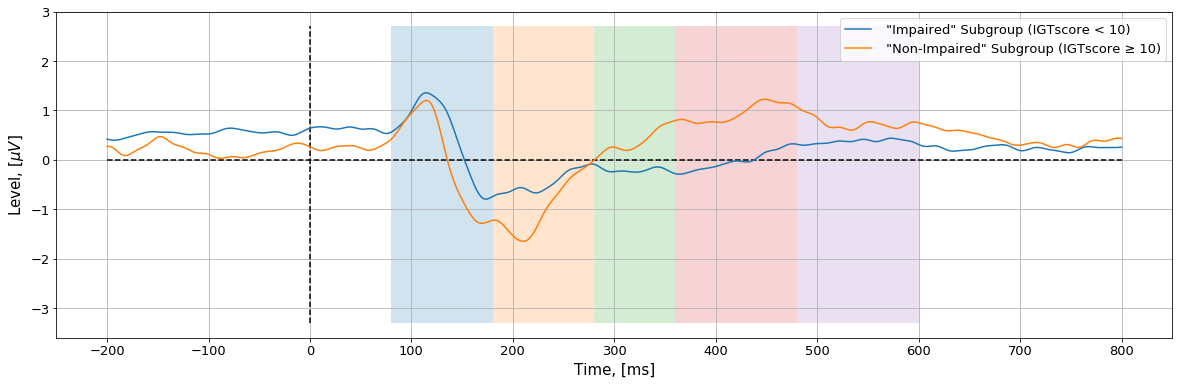

In [31]:
a_mean = EEGTotal_0_mean.to_frame()
a_mean['Time'] = pd.DataFrame(np.arange(-200, 801))
a_mean.columns = ['Level', 'Time']

b_mean = EEGTotal_1_mean.to_frame()
b_mean['Time'] = pd.DataFrame(np.arange(-200, 801))
b_mean.columns = ['Level', 'Time']

plt.figure(figsize=(20, 6))
  
plt.plot(a_mean['Time'], a_mean['Level'])
plt.plot(b_mean['Time'], b_mean['Level'])

plt.hlines(0, -200, 800, colors='black', linestyles='dashed')
plt.vlines(0, -3.3, 2.7, colors='black', linestyles='dashed')
plt.grid()
plt.xlabel('Time, [ms]', size='15')
plt.ylabel('Level, [$\mu V$]', size='15')
yy = np.arange(-3.3, 3.3)
plt.fill_betweenx(yy,  80, 180, alpha=0.2)
plt.fill_betweenx(yy, 180, 280, alpha=0.2)
plt.fill_betweenx(yy, 280, 360, alpha=0.2)
plt.fill_betweenx(yy, 360, 480, alpha=0.2)
plt.fill_betweenx(yy, 480, 600, alpha=0.2)
plt.yticks(fontsize=13)
plt.xticks(np.arange(-200, 801, step=100), fontsize=13)
plt.legend([' "Impaired" Subgroup (IGTscore < 10)', ' "Non-Impaired" Subgroup (IGTscore ≥ 10)'], fontsize=13)

plt.show()

In [99]:
def plot_wavelet(time, signal, scales, 
                 waveletname = 'cmor', 
                 cmap = plt.cm.seismic, 
                 title = 'Wavelet Transform (Power Spectrum) of signal', 
                 ylabel = 'Period', 
                 xlabel = 'Time'):
    
    dt = time[1] - time[0]
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)
    power = (abs(coefficients)) ** 2
    period = 1. / frequencies
    levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
    contourlevels = np.log2(levels)
    
    fig, ax = plt.subplots(figsize=(15, 10))
    im = ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both',cmap=cmap)
    
    ax.set_title(title, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=18)
    
    yticks = 2**np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))
    ax.set_yticks(np.log2(yticks))
    ax.set_yticklabels(yticks)
    ax.invert_yaxis()
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], -1)
    
    cbar_ax = fig.add_axes([0.95, 0.5, 0.03, 0.25])
    fig.colorbar(im, cax=cbar_ax, orientation="vertical")
    plt.show()



time = np.arange(-200, 801)

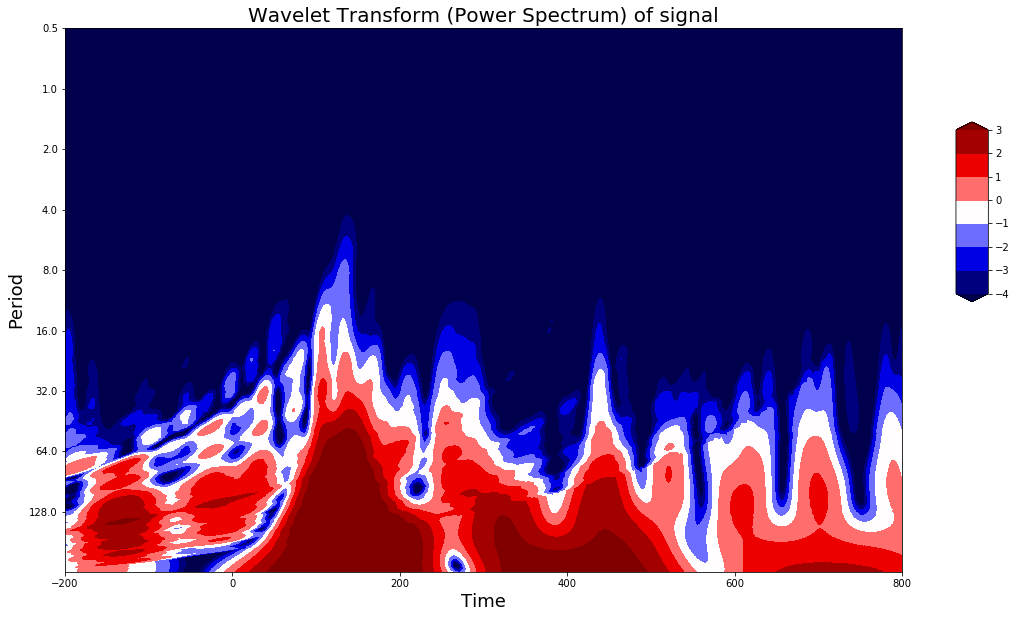

In [100]:
signal = EEGdata_avg01[:1001]

scales = np.arange(0.1, 128)
plot_wavelet(time, signal, scales)

In [101]:
scales = np.arange(0.1, 128)
waveletname = 'morl'
coeff, freq = pywt.cwt(EEGdata_avg01[:1001], scales, waveletname, 1)
print(coeff.shape)

(128, 1001)


# **5.0 ML Application** 

In [32]:
def plot_history_acc(history):
    plt.plot(history.history['accuracy'], 
            label='accuracy on training set')
    plt.plot(history.history['val_accuracy'], 
            label='accuracy on validation set')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

def plot_history_loss(history):
    plt.plot(history.history['loss'], 
         label='loss on training set')
    plt.plot(history.history['val_loss'], 
         label='loss on validation set')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

In [33]:
def STANDARDIZATION(X):
    PredictorScaler = StandardScaler()
    PredictorScalerFit = PredictorScaler.fit(X)
    X = PredictorScalerFit.transform(X)
    return X

In [34]:
def ANNclassifier(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
    D = X_train.shape[1]
    
    history = History()
    
    classifier = Sequential()
    
    classifier.add(Dense(units=10, input_dim=D, kernel_initializer='uniform', activation='relu'))
    classifier.add(Dropout(0.3, input_shape=(X_train.shape[1],))) 
    classifier.add(Dense(units=8, kernel_initializer='normal', activation='relu'))
    classifier.add(Dropout(0.3))
    classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
    classifier.compile(loss=tf.keras.losses.BinaryCrossentropy(reduction='none'), optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['accuracy'])
    
    history = classifier.fit(X_train, y_train, batch_size=800, epochs=70, verbose=0, validation_data=(X_test, y_test), shuffle=True, callbacks=[history])
    train_score = classifier.evaluate(X_train, y_train, verbose=0)
    test_score = classifier.evaluate(X_test, y_test, verbose=0)
    
    return train_score[1], test_score[1]

In [35]:
def RFclassifier(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
    clf = RandomForestClassifier(n_estimators=1000)
    clf.fit(X_train, y_train)
    
    return clf.score(X_train, y_train), clf.score(X_test, y_test)

In [36]:
def SVMclassifier(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
    clf = svm.SVC(kernel='rbf', C=1, random_state=42)
    clf.fit(X_train, y_train)
    
    return clf.score(X_train, y_train), clf.score(X_test, y_test)

In [37]:
def CNNclassifier(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
    X_train = np.expand_dims(X_train, axis = -1)
    X_test = np.expand_dims(X_test, axis = -1)   
    D = X_train.shape[1]
    
    history = History()
    
    img_x = D
    img_y = 1
    input_shape = (img_x, img_y)
    
    num_classes = 2
    batch_size = 800
    epochs = 100
    
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
 
    y_train = tf.keras.utils.to_categorical(y_train, num_classes)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes)
 
    model = Sequential()
    model.add(Conv1D(32, kernel_size=5, strides=1, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(64, 5, activation='relu'))
    model.add(SpatialDropout1D(0.6))
    model.add(Conv1D(64, 5, activation='relu'))
    model.add(SpatialDropout1D(0.6))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(reduction='none'), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy'])

    model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          validation_data=(X_test, y_test), 
          shuffle=True, 
          callbacks=[history])
 
    train_score = model.evaluate(X_train, y_train, verbose=0)
    test_score = model.evaluate(X_test, y_test, verbose=0)
    y_test_pred = (model.predict(X_test) > 0.5).astype(int)
    
    return train_score[1], test_score[1]

In [38]:
def CNNclassifier3D(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
    X_train = np.expand_dims(X_train, axis = -1)
    X_test = np.expand_dims(X_test, axis = -1)   
    D1 = X_train.shape[1]
    D2 = X_train.shape[2]
    
    history = History() 
    
    img_x = D1
    img_y = D2
    img_z = 1
    input_shape = (img_x, img_y, img_z) 
    
    num_classes = 2
    batch_size = 800
    epochs = 70
 
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')

    y_train = tf.keras.utils.to_categorical(y_train, num_classes)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes)
 
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(64, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              metrics=['accuracy'])

    model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          validation_data=(X_test, y_test), 
          shuffle=True, 
          callbacks=[history])
 
    train_score = model.evaluate(X_train, y_train, verbose=0)
    test_score = model.evaluate(X_test, y_test, verbose=0)
    y_test_pred = (model.predict(X_test) > 0.5).astype(int)
    
    return train_score[1], test_score[1]

In [45]:
#### 1 peaks_features_ERN ###

In [56]:
X_peaks  = STANDARDIZATION(peaks_features_1000ms)

y = np.array(y)

print('fft_psd_acf_features')
resultANN = ANNclassifier(X_peaks, y)
print('ANN: Train accuracy: {}, Test accuracy: {}'.format(resultANN[0], resultANN[1]))
resultRF = RFclassifier(X_peaks, y)
print('RF : Train accuracy: {}, Test accuracy: {}'.format(resultRF[0], resultRF[1]))
resultSVM = SVMclassifier(X_peaks, y)
print('SVM: Train accuracy: {}, Test accuracy: {}'.format(resultSVM[0], resultSVM[1]))
resultCNN = CNNclassifier(X_peaks, y)
print('CNN: Train accuracy: {}, Test accuracy: {}'.format(resultCNN[0], resultCNN[1]))
print('')

fft_psd_acf_features
ANN: Train accuracy: 0.7635279297828674, Test accuracy: 0.7201278209686279
RF : Train accuracy: 0.9978696207925011, Test accuracy: 0.7987220447284346
SVM: Train accuracy: 0.8155091606305922, Test accuracy: 0.7175718849840256
CNN: Train accuracy: 0.9740093946456909, Test accuracy: 0.8236421942710876



In [57]:
X_peaks_ern  = STANDARDIZATION(peaks_features_ERN)
X_peaks_p200 = STANDARDIZATION(peaks_features_P200)
X_peaks_frn  = STANDARDIZATION(peaks_features_FRN)
X_peaks_p300 = STANDARDIZATION(peaks_features_P300)
X_peaks_n500 = STANDARDIZATION(peaks_features_N500)
y = np.array(y)

print('peaks_features_ERN')
resultANN = ANNclassifier(X_peaks_ern, y)
print('ANN: Train accuracy: {}, Test accuracy: {}'.format(resultANN[0], resultANN[1]))
resultRF = RFclassifier(X_peaks_ern, y)
print('RF : Train accuracy: {}, Test accuracy: {}'.format(resultRF[0], resultRF[1]))
resultSVM = SVMclassifier(X_peaks_ern, y)
print('SVM: Train accuracy: {}, Test accuracy: {}'.format(resultSVM[0], resultSVM[1]))
resultCNN = CNNclassifier(X_peaks_ern, y)
print('CNN: Train accuracy: {}, Test accuracy: {}'.format(resultCNN[0], resultCNN[1]))
print('')

print('peaks_features_P200')
resultANN = ANNclassifier(X_peaks_p200, y)
print('ANN: Train accuracy: {}, Test accuracy: {}'.format(resultANN[0], resultANN[1]))
resultRF = RFclassifier(X_peaks_p200, y)
print('RF : Train accuracy: {}, Test accuracy: {}'.format(resultRF[0], resultRF[1]))
resultSVM = SVMclassifier(X_peaks_p200, y)
print('SVM: Train accuracy: {}, Test accuracy: {}'.format(resultSVM[0], resultSVM[1]))
resultCNN = CNNclassifier(X_peaks_p200, y)
print('CNN: Train accuracy: {}, Test accuracy: {}'.format(resultCNN[0], resultCNN[1]))
print('')

print('peaks_features_FRN')
resultANN = ANNclassifier(X_peaks_frn, y)
print('ANN: Train accuracy: {}, Test accuracy: {}'.format(resultANN[0], resultANN[1]))
resultRF = RFclassifier(X_peaks_frn, y)
print('RF : Train accuracy: {}, Test accuracy: {}'.format(resultRF[0], resultRF[1]))
resultSVM = SVMclassifier(X_peaks_frn, y)
print('SVM: Train accuracy: {}, Test accuracy: {}'.format(resultSVM[0], resultSVM[1]))
resultCNN = CNNclassifier(X_peaks_frn, y)
print('CNN: Train accuracy: {}, Test accuracy: {}'.format(resultCNN[0], resultCNN[1]))
print('')

print('peaks_features_P300')
resultANN = ANNclassifier(X_peaks_p300, y)
print('ANN: Train accuracy: {}, Test accuracy: {}'.format(resultANN[0], resultANN[1]))
resultRF = RFclassifier(X_peaks_p300, y)
print('RF : Train accuracy: {}, Test accuracy: {}'.format(resultRF[0], resultRF[1]))
resultSVM = SVMclassifier(X_peaks_p300, y)
print('SVM: Train accuracy: {}, Test accuracy: {}'.format(resultSVM[0], resultSVM[1]))
resultCNN = CNNclassifier(X_peaks_p300, y)
print('CNN: Train accuracy: {}, Test accuracy: {}'.format(resultCNN[0], resultCNN[1]))
print('')

print('peaks_features_N500')
resultANN = ANNclassifier(X_peaks_n500, y)
print('ANN: Train accuracy: {}, Test accuracy: {}'.format(resultANN[0], resultANN[1]))
resultRF = RFclassifier(X_peaks_n500, y)
print('RF : Train accuracy: {}, Test accuracy: {}'.format(resultRF[0], resultRF[1]))
resultSVM = SVMclassifier(X_peaks_n500, y)
print('SVM: Train accuracy: {}, Test accuracy: {}'.format(resultSVM[0], resultSVM[1]))
resultCNN = CNNclassifier(X_peaks_n500, y)
print('CNN: Train accuracy: {}, Test accuracy: {}'.format(resultCNN[0], resultCNN[1]))
print('')

peaks_features_ERN
ANN: Train accuracy: 0.657008945941925, Test accuracy: 0.5827475786209106
RF : Train accuracy: 0.9684703877290157, Test accuracy: 0.615335463258786
SVM: Train accuracy: 0.6847038772901577, Test accuracy: 0.5884984025559106
CNN: Train accuracy: 0.718363881111145, Test accuracy: 0.5853034853935242

peaks_features_P200
ANN: Train accuracy: 0.645504891872406, Test accuracy: 0.604472815990448
RF : Train accuracy: 0.9723050703025139, Test accuracy: 0.6351437699680511
SVM: Train accuracy: 0.6736259054111632, Test accuracy: 0.6031948881789138
CNN: Train accuracy: 0.7094162702560425, Test accuracy: 0.6332268118858337

peaks_features_FRN
ANN: Train accuracy: 0.6109927296638489, Test accuracy: 0.5757188200950623
RF : Train accuracy: 0.9271410311035364, Test accuracy: 0.5897763578274761
SVM: Train accuracy: 0.6263314870046869, Test accuracy: 0.5712460063897764
CNN: Train accuracy: 0.6467831134796143, Test accuracy: 0.5782747864723206

peaks_features_P300
ANN: Train accuracy: 0.5

In [58]:
## 2 DWT features ###

In [59]:
X_dwt  = STANDARDIZATION(dwt_features_1000ms)

y = np.array(y)

print('dwt_features')
resultANN = ANNclassifier(X_dwt, y)
print('ANN: Train accuracy: {}, Test accuracy: {}'.format(resultANN[0], resultANN[1]))
resultRF = RFclassifier(X_dwt, y)
print('RF : Train accuracy: {}, Test accuracy: {}'.format(resultRF[0], resultRF[1]))
resultSVM = SVMclassifier(X_dwt, y)
print('SVM: Train accuracy: {}, Test accuracy: {}'.format(resultSVM[0], resultSVM[1]))
resultCNN = CNNclassifier(X_dwt, y)
print('CNN: Train accuracy: {}, Test accuracy: {}'.format(resultCNN[0], resultCNN[1]))
print('')

dwt_features
ANN: Train accuracy: 0.7302939891815186, Test accuracy: 0.650479257106781
RF : Train accuracy: 1.0, Test accuracy: 0.7258785942492013
SVM: Train accuracy: 0.8547081380485726, Test accuracy: 0.7099041533546326
CNN: Train accuracy: 0.9075415134429932, Test accuracy: 0.7207667827606201



In [60]:
X_dwt_ern  = STANDARDIZATION(dwt_features_ERN)
X_dwt_p200 = STANDARDIZATION(dwt_features_P200)
X_dwt_frn  = STANDARDIZATION(dwt_features_FRN)
X_dwt_p300 = STANDARDIZATION(dwt_features_P300)
X_dwt_n500 = STANDARDIZATION(dwt_features_N500)
y = np.array(y)

print('dwt_features_ERN')
resultANN = ANNclassifier(X_dwt_ern, y)
print('ANN: Train accuracy: {}, Test accuracy: {}'.format(resultANN[0], resultANN[1]))
resultRF = RFclassifier(X_dwt_ern, y)
print('RF : Train accuracy: {}, Test accuracy: {}'.format(resultRF[0], resultRF[1]))
resultSVM = SVMclassifier(X_dwt_ern, y)
print('SVM: Train accuracy: {}, Test accuracy: {}'.format(resultSVM[0], resultSVM[1]))
resultCNN = CNNclassifier(X_dwt_ern, y)
print('CNN: Train accuracy: {}, Test accuracy: {}'.format(resultCNN[0], resultCNN[1]))
print('')

print('dwt_features_P200')
resultANN = ANNclassifier(X_dwt_p200, y)
print('ANN: Train accuracy: {}, Test accuracy: {}'.format(resultANN[0], resultANN[1]))
resultRF = RFclassifier(X_dwt_p200, y)
print('RF : Train accuracy: {}, Test accuracy: {}'.format(resultRF[0], resultRF[1]))
resultSVM = SVMclassifier(X_dwt_p200, y)
print('SVM: Train accuracy: {}, Test accuracy: {}'.format(resultSVM[0], resultSVM[1]))
resultCNN = CNNclassifier(X_dwt_p200, y)
print('CNN: Train accuracy: {}, Test accuracy: {}'.format(resultCNN[0], resultCNN[1]))
print('')

print('dwt_features_FRN')
resultANN = ANNclassifier(X_dwt_frn, y)
print('ANN: Train accuracy: {}, Test accuracy: {}'.format(resultANN[0], resultANN[1]))
resultRF = RFclassifier(X_dwt_frn, y)
print('RF : Train accuracy: {}, Test accuracy: {}'.format(resultRF[0], resultRF[1]))
resultSVM = SVMclassifier(X_dwt_frn, y)
print('SVM: Train accuracy: {}, Test accuracy: {}'.format(resultSVM[0], resultSVM[1]))
resultCNN = CNNclassifier(X_dwt_frn, y)
print('CNN: Train accuracy: {}, Test accuracy: {}'.format(resultCNN[0], resultCNN[1]))
print('')

print('dwt_features_P300')
resultANN = ANNclassifier(X_dwt_p300, y)
print('ANN: Train accuracy: {}, Test accuracy: {}'.format(resultANN[0], resultANN[1]))
resultRF = RFclassifier(X_dwt_p300, y)
print('RF : Train accuracy: {}, Test accuracy: {}'.format(resultRF[0], resultRF[1]))
resultSVM = SVMclassifier(X_dwt_p300, y)
print('SVM: Train accuracy: {}, Test accuracy: {}'.format(resultSVM[0], resultSVM[1]))
resultCNN = CNNclassifier(X_dwt_p300, y)
print('CNN: Train accuracy: {}, Test accuracy: {}'.format(resultCNN[0], resultCNN[1]))
print('')

print('dwt_features_N500')
resultANN = ANNclassifier(X_dwt_n500, y)
print('ANN: Train accuracy: {}, Test accuracy: {}'.format(resultANN[0], resultANN[1]))
resultRF = RFclassifier(X_dwt_n500, y)
print('RF : Train accuracy: {}, Test accuracy: {}'.format(resultRF[0], resultRF[1]))
resultSVM = SVMclassifier(X_dwt_n500, y)
print('SVM: Train accuracy: {}, Test accuracy: {}'.format(resultSVM[0], resultSVM[1]))
resultCNN = CNNclassifier(X_dwt_n500, y)
print('CNN: Train accuracy: {}, Test accuracy: {}'.format(resultCNN[0], resultCNN[1]))
print('')

dwt_features_ERN
ANN: Train accuracy: 0.6514699459075928, Test accuracy: 0.589776337146759
RF : Train accuracy: 1.0, Test accuracy: 0.6140575079872205
SVM: Train accuracy: 0.7413719642096294, Test accuracy: 0.5897763578274761
CNN: Train accuracy: 0.7809970378875732, Test accuracy: 0.5968050956726074

dwt_features_P200
ANN: Train accuracy: 0.6561567783355713, Test accuracy: 0.6108626127243042
RF : Train accuracy: 1.0, Test accuracy: 0.6178913738019169
SVM: Train accuracy: 0.7341286749041329, Test accuracy: 0.6083067092651757
CNN: Train accuracy: 0.7801448702812195, Test accuracy: 0.5923322439193726

dwt_features_FRN
ANN: Train accuracy: 0.6322965621948242, Test accuracy: 0.5610223412513733
RF : Train accuracy: 1.0, Test accuracy: 0.5482428115015975
SVM: Train accuracy: 0.7362590541116318, Test accuracy: 0.5731629392971246
CNN: Train accuracy: 0.7571367621421814, Test accuracy: 0.5597444176673889

dwt_features_P300
ANN: Train accuracy: 0.6391137838363647, Test accuracy: 0.561661362648010

In [ ]:
.........
features = preprocessin
.........

In [ ]:
## 3 cwt features ##

In [ ]:
X_cwt   = np.array(cwt_features_1000ms) / np.sqrt(np.sum((np.array(cwt_features_1000ms))**2))

y = np.array(y)

print('cwt_features')
resultCNN = CNNclassifier3D(X_cwt, y)
print('CNN: Train accuracy: {}, Test accuracy: {}'.format(resultCNN[0], resultCNN[1]))
print('')

In [ ]:
X_cwt_ern   = np.array(cwt_features_ERN) / np.sqrt(np.sum((np.array(cwt_features_ERN))**2))
X_cwt_p200  = np.array(cwt_features_P200) / np.sqrt(np.sum((np.array(cwt_features_P200))**2))
X_cwt_frn   = np.array(cwt_features_FRN) / np.sqrt(np.sum((np.array(cwt_features_FRN))**2))
X_cwt_p300  = np.array(cwt_features_P300) / np.sqrt(np.sum((np.array(cwt_features_P300))**2))
X_cwt_n500  = np.array(cwt_features_N500) / np.sqrt(np.sum((np.array(cwt_features_N500))**2))
y = np.array(y)

print('cwt_features_ERN')
resultCNN = CNNclassifier3D(X_cwt_ern, y)
print('CNN: Train accuracy: {}, Test accuracy: {}'.format(resultCNN[0], resultCNN[1]))
print('')

print('cwt_features_P200')
resultCNN = CNNclassifier3D(X_cwt_p200, y)
print('CNN: Train accuracy: {}, Test accuracy: {}'.format(resultCNN[0], resultCNN[1]))
print('')

print('cwt_features_FRN')
resultCNN = CNNclassifier3D(X_cwt_frn, y)
print('CNN: Train accuracy: {}, Test accuracy: {}'.format(resultCNN[0], resultCNN[1]))
print('')

print('cwt_features_P300')
resultCNN = CNNclassifier3D(X_cwt_p300, y)
print('CNN: Train accuracy: {}, Test accuracy: {}'.format(resultCNN[0], resultCNN[1]))
print('')

print('cwt_features_N500')
resultCNN = CNNclassifier3D(X_cwt_n500, y)
print('CNN: Train accuracy: {}, Test accuracy: {}'.format(resultCNN[0], resultCNN[1]))
print('')

In [ ]:
#######

In [ ]:
## Improvements:

In [61]:
X_peaks  = STANDARDIZATION(peaks_features_1000ms)
y = np.array(y)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X_peaks, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

clf = RandomForestClassifier(n_estimators=5000)
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print("Accuracy on training set is : {}".format(clf.score(X_train, y_train)))
print("Accuracy on test set is : {}".format(clf.score(X_test, y_test)))
print(classification_report(y_test, y_test_pred))

Accuracy on training set is : 0.9980824544582934
Accuracy on test set is : 0.8084291187739464
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       415
           1       0.83      0.74      0.79       368

    accuracy                           0.81       783
   macro avg       0.81      0.80      0.81       783
weighted avg       0.81      0.81      0.81       783



In [67]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3129, 300), (783, 300), (3129,), (783,))

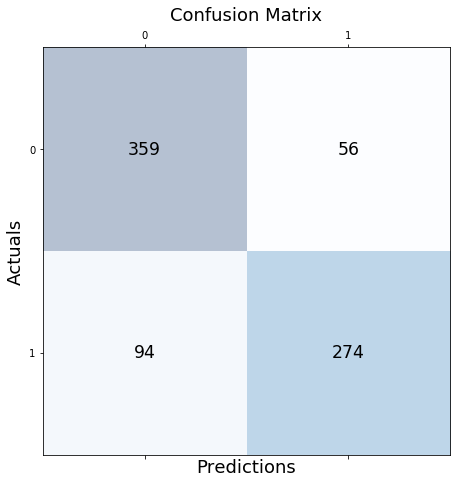

In [68]:
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_test_pred)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [69]:
def plot_history_acc(history):
    plt.plot(history.history['accuracy'], 
            label='accuracy on training set')
    plt.plot(history.history['val_accuracy'], 
            label='accuracy on testing set')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

def plot_history_loss(history):
    plt.plot(history.history['loss'], 
         label='loss on training set')
    plt.plot(history.history['val_loss'], 
         label='loss on testing set')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

In [70]:
X_peaks  = STANDARDIZATION(peaks_features_1000ms)
y = np.array(y)

Train loss: 0.18889345228672028, Train accuracy: 0.923298180103302
Test loss: 0.3750952482223511, Test accuracy: 0.8416347503662109
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       415
           1       0.84      0.82      0.83       368

   micro avg       0.84      0.84      0.84       783
   macro avg       0.84      0.84      0.84       783
weighted avg       0.84      0.84      0.84       783
 samples avg       0.84      0.84      0.84       783



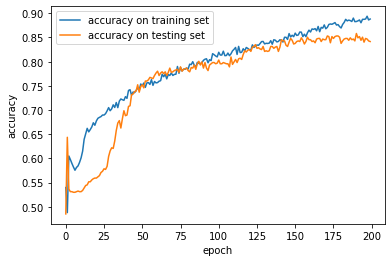

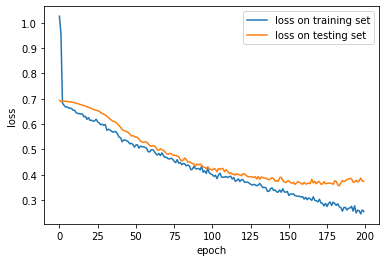

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X_peaks, y, test_size=0.2, random_state=42)
X_train = np.expand_dims(X_train, axis = -1)
X_test = np.expand_dims(X_test, axis = -1)   
D = X_train.shape[1]

history = History()
    
img_x = D
img_y = 1
input_shape = (img_x, img_y)
    
num_classes = 2
batch_size = 1000
epochs = 200
    
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
 
model = Sequential()
model.add(Conv1D(32, kernel_size=5, strides=1, activation='relu', input_shape=input_shape))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(SpatialDropout1D(0.8))

model.add(Conv1D(64, 5, activation='relu'))
model.add(SpatialDropout1D(0.8))
model.add(Conv1D(64, 5, activation='relu'))
model.add(SpatialDropout1D(0.8))

model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss=tf.keras.losses.BinaryCrossentropy(reduction='none'), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy'])

model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          validation_data=(X_test, y_test), 
          shuffle=True, 
          callbacks=[history])
 
train_score = model.evaluate(X_train, y_train, verbose=0)
test_score = model.evaluate(X_test, y_test, verbose=0)
y_test_pred = (model.predict(X_test) > 0.5).astype(int)

print('Train loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))  

print(classification_report(y_test, y_test_pred))

plot_history_acc(history)
plot_history_loss(history)

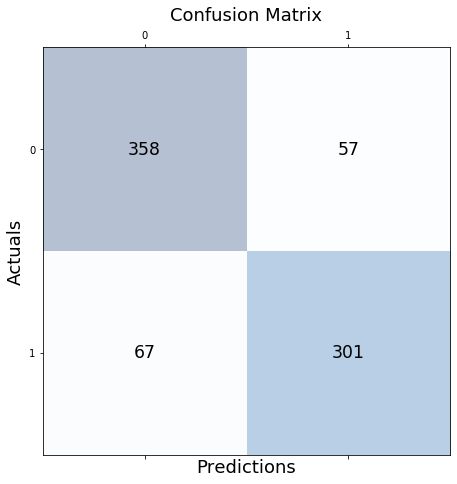

In [80]:
y_test_2=y_test.astype(int)


conf_matrix = confusion_matrix(y_true=y_test_2.argmax(axis=1), y_pred=y_test_pred.argmax(axis=1))
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [138]:
os.chdir('C:/Users/dkornev/Desktop/Work Folder/My Folders/Harrisburg University/ISEM 780-52-A-2021 Fall - Doctoral Research Seminar/S01')
os.getcwd()

'C:\\Users\\dkornev\\Desktop\\Work Folder\\My Folders\\Harrisburg University\\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\\S01'



Files Loading:  S01.edf.mrk S01.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\S01\S01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 1843999  =      0.000 ...  1843.999 secs...

=== REJECT ===
Not setting metadata
1844 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1844 events and 1001 original time points ...
1 bad epochs dropped

=== ICA ===
Estimating rejection dictionary for eeg
rejection threshold:  {'eeg': 5.978773516675648e-05}
Fitting ICA to data using 49 channels (please be patient, this may take a while)


<ipython-input-7-efa77eb1992e>:5: RuntimeWarning: The following parameters passed to ICA.fit() will be ignored, as they only affect raw data (and it appears you passed epochs): reject
  ica.fit(epochs_ica, reject=reject_thr, tstep=1.0)


Selecting by explained variance: 26 components
Fitting ICA took 131.4s.

=== ARTIFACTS ===
Applying ICA to Raw instance
    Transforming to ICA space (26 components)
    Zeroing out 18 ICA components
    Projecting back using 49 PCA components

=== PLOT ===


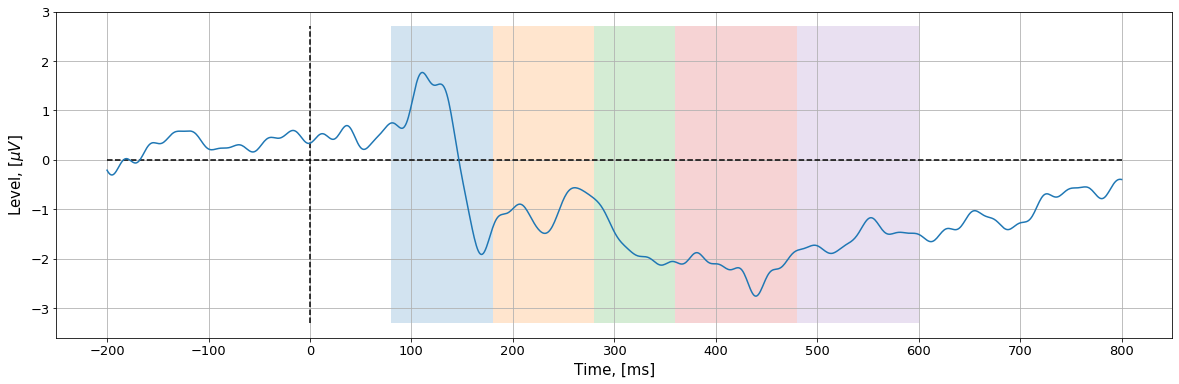

Files Loaded:  S01.edf.mrk S01.edf
Events number in record:  200
Columns Name:  RangeIndex(start=0, stop=200, step=1)



C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 121, using nperseg = 121
  warnings.warn('nperseg = {0:d} is greater than input length '


In [139]:
peaks_features_ERN,  peaks_features_P200, peaks_features_FRN, peaks_features_P300, peaks_features_N500, \
  dwt_features_ERN,    dwt_features_P200,   dwt_features_FRN,   dwt_features_P300,   dwt_features_N500, \
  cwt_features_ERN,    cwt_features_P200,   cwt_features_FRN,   cwt_features_P300,   cwt_features_N500, \
  peaks_features_1000ms, \
  dwt_features_1000ms, \
  cwt_features_1000ms, \
  y = get_signal_features(data_dir = './', 
                          cwt_waveletname = 'morl', 
                          dwt_waveletname = 'db4', 
                          denominator = 10, 
                          percentile = 5, 
                          n_peaks = 50)

In [140]:
np.array(peaks_features_1000ms).shape

(200, 300)

In [141]:
np.array(y).shape, np.unique(y)

((200,), array([0]))

In [142]:
X_peaks  = STANDARDIZATION(peaks_features_1000ms)
y = np.array(y)

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X_peaks, y, test_size=0.2, random_state=42)
X_train = np.expand_dims(X_train, axis = -1)
X_test = np.expand_dims(X_test, axis = -1)   
D = X_train.shape[1]

In [156]:
S01_pred = (model.predict(X_test) > 0.5).astype(int)
S01_pred.shape

(40, 2)

In [153]:
y_test.shape

(40,)

In [157]:
S01_pred.argmax(axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [158]:
print(classification_report(y_test, S01_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        40
           1       0.00      0.00      0.00         0

    accuracy                           0.90        40
   macro avg       0.50      0.45      0.47        40
weighted avg       1.00      0.90      0.95        40



C:\Users\dkornev\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dkornev\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dkornev\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [159]:
from sklearn.metrics import accuracy_score

In [160]:
accuracy_score(y_test, S01_pred.argmax(axis=1))

0.9

In [ ]:
#########

In [ ]:
# AutoML

In [ ]:
# 1. P200

In [102]:
X_peaks_p200 = STANDARDIZATION(peaks_features_P300)
y = np.array(y)

In [105]:
X_peaks_p200.shape, y.shape, np.unique(y)

((3912, 300), (3912,), array([0, 1]))

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X_peaks_p200, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3129, 300), (783, 300), (3129,), (783,))

In [106]:
!pip install autokeras
import autokeras as ak

INFO: pip is looking at multiple versions of tensorflow-text to determine which version is compatible with other requirements. This could take a while.


In [119]:
from tensorflow.keras.callbacks import EarlyStopping
from autokeras import StructuredDataClassifier
import time

In [116]:
# Обучение модели
# Определение EarlyStopping-коллбека
es_callback = EarlyStopping(monitor='val_loss', patience=4)
start_time = time.time()
clf_3 = ak.ImageClassifier(overwrite=True, 
                           max_trials=25, 
                           num_classes=2, 
                           multi_label=False, 
                           loss="binary_crossentropy", 
                           metrics=["accuracy"], 
                           project_name="my_project", 
                           directory="my_dir", 
                           seed=44, 
                           max_model_size=None, 
                           objective ='val_accuracy')

# Обучаем 10  моделей
clf_3.fit(X_train, y_train, 
          epochs=10, 
          batch_size=64, 
          allbacks=[es_callback], 
          validation_data=(X_test, y_test))

end_time = time.time()
# Вывод времени обучения и точности модели
print("Total training time:", end_time - start_time) 
print("Training accuracy:", clf_3.evaluate(X_train, y_train)[1])
print("Test accuracy:", clf_3.evaluate(X_test, y_test)[1])

In [130]:
clf_autoML = ak.StructuredDataClassifier(
    column_names=None,
    column_types=None,
    num_classes=2,
    multi_label=False,
    loss="binary_crossentropy",
    metrics="accuracy",
    project_name=None,
    max_trials=10,
    directory=None,
    objective="val_accuracy",
    tuner="bayesian",
    overwrite=True,
    seed=44,
    max_model_size=None)

In [131]:
history = History()

clf_autoML.fit(x=X_train, y=y_train, 
               epochs=10,
               batch_size=64,
               callbacks=[history], 
               validation_data=(X_test, y_test),
               verbose=0)

print("Training accuracy:", clf_autoML.evaluate(X_train, y_train)[1], verbose=0)
print("Test accuracy:", clf_autoML.evaluate(X_test, y_test)[1], verbose=0)

Trial 10 Complete [00h 00m 04s]

Best val_accuracy So Far: 0.5657726526260376
Total elapsed time: 00h 08m 17s
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
49/49 [==============================] - 8s 70ms/step - loss: 0.7642 - accuracy: 0.5292 - val_loss: 0.7046 - val_accuracy: 0.4968
Epoch 2/10
49/49 [==============================] - 1s 19ms/step - loss: 0.7064 - accuracy: 0.5580 - val_loss: 0.6975 - val_accuracy: 0.5160
Epoch 3/10
49/49 [==============================] - 1s 22ms/step - loss: 0.6782 - accuracy: 0.5932 - val_loss: 0.7031 - val_accuracy: 0.5249
Epoch 4/10
49/49 [==============================] - 1s 22ms/step - loss: 0.6615 - accuracy: 0.6136 - val_loss: 0.7041 - val_accuracy: 0.5262
Epoch 5/10
49/49 [==============================] - 1s 27ms/step - loss: 0.6462 - accuracy: 0.6181 - val_loss: 0.6989 - val_accuracy: 0.5581
Epoch 6/10
49/49 [==============================] - 1s 30ms/step - loss: 0.6258 - accuracy: 0.6488 - val_loss: 0.7085 - val_accuracy: 0.5338
Epoch 

In [132]:
best_models = clf_autoML.tuner.get_best_models(num_models=1)
best_models[0].summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300)]             0         
                                                                 
 multi_category_encoding (Mu  (None, 300)              0         
 ltiCategoryEncoding)                                            
                                                                 
 dense (Dense)               (None, 256)               77056     
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1024)              263168

In [ ]:
#2. 1000ms interval

In [133]:
X_peaks  = STANDARDIZATION(peaks_features_1000ms)
y = np.array(y)

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X_peaks, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3129, 300), (783, 300), (3129,), (783,))

In [136]:
clf_autoML = ak.StructuredDataClassifier(
    column_names=None,
    column_types=None,
    num_classes=2,
    multi_label=False,
    loss="binary_crossentropy",
    metrics="accuracy",
    project_name=None,
    max_trials=10,
    directory=None,
    objective="val_accuracy",
    tuner="bayesian",
    overwrite=True,
    seed=44,
    max_model_size=None)

history = History()

clf_autoML.fit(x=X_train, y=y_train, 
               epochs=10,
               batch_size=64,
               callbacks=[history], 
               validation_data=(X_test, y_test),
               verbose=0)

train_score = clf_autoML.evaluate(X_train, y_train, verbose=0)
test_score = clf_autoML.evaluate(X_test, y_test, verbose=0)

print("Training accuracy:", train_score[1])
print("Test accuracy:", test_score[1])

Traceback (most recent call last):
  File "C:\Users\dkornev\Anaconda3\lib\site-packages\keras_tuner\engine\base_tuner.py", line 266, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\dkornev\Anaconda3\lib\site-packages\keras_tuner\engine\base_tuner.py", line 231, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\dkornev\Anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\dkornev\Anaconda3\lib\site-packages\autokeras\engine\tuner.py", line 91, in _build_and_fit_model
    model = self._try_build(trial.hyperparameters)
  File "C:\Users\dkornev\Anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 155, in _try_build
    model = self._build_hypermodel(hp)
  File "C:\Users\dkornev\Anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 146, in _buil

INFO:tensorflow:Oracle triggered exit


Traceback (most recent call last):
  File "C:\Users\dkornev\Anaconda3\lib\site-packages\keras_tuner\engine\base_tuner.py", line 266, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\dkornev\Anaconda3\lib\site-packages\keras_tuner\engine\base_tuner.py", line 231, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\dkornev\Anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\dkornev\Anaconda3\lib\site-packages\autokeras\engine\tuner.py", line 91, in _build_and_fit_model
    model = self._try_build(trial.hyperparameters)
  File "C:\Users\dkornev\Anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 155, in _try_build
    model = self._build_hypermodel(hp)
  File "C:\Users\dkornev\Anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 146, in _buil

INFO:tensorflow:Assets written to: .\untitled_project\best_model\assets
Training accuracy: 0.907318651676178
Test accuracy: 0.7164750695228577


In [ ]:
########

In [ ]:
########

In [ ]:
X_dwt_ern  = STANDARDIZATION(dwt_features_ERN)
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X_dwt_ern, y, test_size=0.4, random_state=42)
D = X_train.shape[1]

In [ ]:
history = History()
classifier = Sequential()
classifier.add(Dense(units=10, input_dim=D, kernel_initializer='uniform', activation='relu'))
classifier.add(Dropout(0.3, input_shape=(X_train.shape[1],))) 
classifier.add(Dense(units=8, kernel_initializer='normal', activation='relu'))
classifier.add(Dropout(0.3))
classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
classifier.compile(loss=tf.keras.losses.BinaryCrossentropy(reduction='none'), 
                   optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
                   metrics=['accuracy'])
history = classifier.fit(X_train, y_train, 
                         batch_size=800, 
                         epochs=200, 
                         verbose=0, 
                         validation_data=(X_test, y_test), 
                         shuffle=True, callbacks=[history])

train_score = classifier.evaluate(X_train, y_train, verbose=1)
print('Train loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
test_score = classifier.evaluate(X_test, y_test, verbose=1)
print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))

y_test_pred = (classifier.predict(X_test) > 0.5).astype(int)

print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred, labels=[1,0]))

plot_history_acc(history)
plot_history_loss(history)

In [ ]:
pred = classifier.predict(X_train)

print((abs(pred - y_train)).mean())  
print(mean_absolute_error(pred, y_train)) 

In [ ]:
def eval_net(model, X_train, y_train, y_scaler = None, n = 10, limit = 2.):
  
    pred = model.predict(X_train)             # Предсказание на тренировочной выборке
    if y_scaler:                              # Если есть нормирование - то денормировать
        pred = y_scaler.inverse_transform(pred)

    print('Средняя абсолютная ошибка:', mean_absolute_error(pred, y_train), '\n')

    
    # Построение картинки разброса предсказанных и верных значений зарплаты
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(y_train, pred)                 # Отрисовка точечного графика
    ax.set_xlim(0, limit)                     # Пределы по x, y
    ax.set_ylim(0, limit)
    ax.plot(plt.xlim(), plt.ylim(), 'r')      # Отрисовка диагональной линии
    plt.xlabel('Правильные значения')
    plt.ylabel('Предсказания')
    plt.grid()
    plt.show() 

In [ ]:
eval_net(classifier, X_train, y_train)

In [ ]:
!pip install scikit-plot==0.3.7
import scikitplot as skplt

In [ ]:
skplt.metrics.plot_confusion_matrix(y_test, y_test_pred, normalize=False, title = 'Confusion Matrix')

In [ ]:
y_pred_proba = classifier.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_test_pred)

plt.figure(figsize=(6, 6))
plt.plot(fpr,tpr,label="AUC="+str(auc))

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import RocCurveDisplay

In [ ]:
RocCurveDisplay.from_predictions(
   y_test, y_test_pred)

plt.show()

In [ ]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

y_pred_proba = classifier.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
clf = RandomForestClassifier(n_estimators=10000)
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print("Accuracy on training set is : {}".format(clf.score(X_train, y_train)))
print("Accuracy on test set is : {}".format(clf.score(X_test, y_test)))
print(classification_report(y_test, y_test_pred))

In [ ]:
y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_test_pred)

plt.figure(figsize=(6, 6))
plt.plot(fpr,tpr,label="AUC="+str(auc))

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

In [ ]:
skplt.metrics.plot_confusion_matrix(y_test, y_test_pred, normalize=False, title = 'Confusion Matrix')

In [ ]:
from PIL import Image 
import PIL 

In [ ]:
img = skplt.metrics.plot_confusion_matrix(y_test, y_test_pred, normalize=False, title = 'Confusion Matrix')

In [ ]:
#########################

In [ ]:
X = np.array(peaks_features_P200)
y = np.array(y)
 
 
### Sandardization of data ###
### We does not standardize the Target variable for classification
from sklearn.preprocessing import StandardScaler
PredictorScaler=StandardScaler()
 
# Storing the fit object for later reference
PredictorScalerFit=PredictorScaler.fit(X)
 
# Generating the standardized values of X and y
X=PredictorScalerFit.transform(X)
 
# Split the data into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
 
# Quick sanity check with the shapes of Training and Testing datasets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

In [ ]:
history = History()

classifier = Sequential()


classifier.add(Dense(units=10, input_dim=300, kernel_initializer='uniform', activation='relu'))

classifier.add(Dropout(0.3, input_shape=(X_train.shape[1],))) 
classifier.add(Dense(units=8, kernel_initializer='uniform', activation='relu'))

classifier.add(Dropout(0.3))
classifier.add(Dense(units=6, kernel_initializer='uniform', activation='relu'))

classifier.add(Dropout(0.3))
classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))

classifier.compile(loss=tf.keras.losses.BinaryCrossentropy(reduction='none'), optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2), metrics=['accuracy'])

history = classifier.fit(X_train, y_train, batch_size=50, epochs=50, verbose=0, validation_split=0.2, shuffle=True, callbacks=[history])

train_score = classifier.evaluate(X_train, y_train, verbose=1)
print('Train loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
test_score = classifier.evaluate(X_test, y_test, verbose=1)
print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))

y_test_pred = (classifier.predict(X_test) > 0.5).astype(int)



print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred, labels=[1,0]))

plot_history_acc(history)
plot_history_loss(history)

In [ ]:
X = np.array(dwt_features_P300)
y = np.array(y)
 
### Standardization of data ###
### We does not standardize the Target variable for classification
from sklearn.preprocessing import StandardScaler
PredictorScaler=StandardScaler()
 
# Storing the fit object for later reference
PredictorScalerFit=PredictorScaler.fit(X)
 
# Generating the standardized values of X and y
X=PredictorScalerFit.transform(X)

 
# Split the data into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
 
# Quick sanity check with the shapes of Training and Testing datasets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

In [ ]:
history = History()

classifier = Sequential()


classifier.add(Dense(units=10, input_dim=165, kernel_initializer='uniform', activation='relu'))

classifier.add(Dropout(0.3, input_shape=(X_train.shape[1],))) 
classifier.add(Dense(units=8, kernel_initializer='normal', activation='relu'))



classifier.add(Dropout(0.3))
classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))

classifier.compile(loss=tf.keras.losses.BinaryCrossentropy(reduction='none'), optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['accuracy'])

history = classifier.fit(X_train, y_train, batch_size=800, epochs=70, verbose=0, validation_data=(X_test, y_test), shuffle=True, callbacks=[history])

train_score = classifier.evaluate(X_train, y_train, verbose=1)
print('Train loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
test_score = classifier.evaluate(X_test, y_test, verbose=1)
print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))

y_test_pred = (classifier.predict(X_test) > 0.5).astype(int)



print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred, labels=[1,0]))

plot_history_acc(history)
plot_history_loss(history)

In [ ]:
clf = RandomForestClassifier(n_estimators=10000)
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print("Accuracy on training set is : {}".format(clf.score(X_train, y_train)))
print("Accuracy on test set is : {}".format(clf.score(X_test, y_test)))
print(classification_report(y_test, y_test_pred))

In [ ]:
clf = svm.SVC(kernel='rbf', C=1, random_state=42)
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print("Accuracy on training set is : {}".format(clf.score(X_train, y_train)))
print("Accuracy on test set is : {}".format(clf.score(X_test, y_test)))
print(classification_report(y_test, y_test_pred))

In [ ]:
cls = GradientBoostingClassifier(n_estimators=2000)
cls.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print("Accuracy on training set is : {}".format(clf.score(X_train, y_train)))
print("Accuracy on test set is : {}".format(clf.score(X_test, y_test)))
print(classification_report(y_test, y_test_pred))

In [ ]:
cls = GradientBoostingClassifier(n_estimators=5000, 
                                 learning_rate = 0.01, 
                                 criterion = 'friedman_mse')
cls.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print("Accuracy on training set is : {}".format(clf.score(X_train, y_train)))
print("Accuracy on test set is : {}".format(clf.score(X_test, y_test)))
print(classification_report(y_test, y_test_pred))

In [ ]:
# Normalization
peaks_features_ERN_norm = preprocessing.normalize(peaks_features_ERN)
cwt_features_ERN_norm   = np.array(cwt_features_ERN) / np.sqrt(np.sum((np.array(cwt_features_ERN))**2))
dwt_features_ERN_norm   = preprocessing.normalize(dwt_features_ERN)

peaks_features_P200_norm = preprocessing.normalize(peaks_features_P200)
cwt_features_P200_norm   = np.array(cwt_features_P200) / np.sqrt(np.sum((np.array(cwt_features_P200))**2))
dwt_features_P200_norm   = preprocessing.normalize(dwt_features_P200)

peaks_features_FRN_norm = preprocessing.normalize(peaks_features_FRN)
cwt_features_FRN_norm   = np.array(cwt_features_FRN) / np.sqrt(np.sum((np.array(cwt_features_FRN))**2))
dwt_features_FRN_norm   = preprocessing.normalize(dwt_features_FRN)

peaks_features_P300_norm = preprocessing.normalize(peaks_features_P300)
cwt_features_P300_norm   = np.array(cwt_features_P300) / np.sqrt(np.sum((np.array(cwt_features_P300))**2))
dwt_features_P300_norm   = preprocessing.normalize(dwt_features_P300)

peaks_features_N500_norm = preprocessing.normalize(peaks_features_N500)
cwt_features_N500_norm   = np.array(cwt_features_N500) / np.sqrt(np.sum((np.array(cwt_features_N500))**2))
dwt_features_N500_norm   = preprocessing.normalize(dwt_features_N500)

In [ ]:
X = np.array(dwt_features_P300_norm)
y = np.array(y)

# Split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
 
# Quick sanity check with the shapes of Training and Testing datasets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

print('___________________')
X_train = np.expand_dims(X_train, axis = -1)
X_test = np.expand_dims(X_test, axis = -1)
X_train.shape, X_test.shape

In [ ]:
# with NORM function
history = History()

img_x = 165
img_y = 1

input_shape = (img_x, img_y)

num_classes = 2
batch_size = 800
epochs = 100
 
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
 
model = Sequential()
model.add(Conv1D(32, kernel_size=5, strides=1,
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling1D(pool_size=2, strides=2))

model.add(Conv1D(64, 5, activation='relu'))
model.add(SpatialDropout1D(0.6))

model.add(Conv1D(64, 5, activation='relu'))
model.add(SpatialDropout1D(0.6))



model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())



model.add(Dense(1000, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
 
model.compile(loss=tf.keras.losses.BinaryCrossentropy(reduction='none'), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy'])

model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          validation_data=(X_test, y_test), 
          shuffle=True, 
          callbacks=[history])
 
train_score = model.evaluate(X_train, y_train, verbose=0)
print('Train loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
test_score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))
y_test_pred = (model.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, y_test_pred))

plot_history_acc(history)
plot_history_loss(history)

In [ ]:
# CWT, 3D array

X = np.array(cwt_features_P300_norm)
y = np.array(y)
 
# Split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
 
# Quick sanity check with the shapes of Training and Testing datasets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

print('___________________')
X_train = np.expand_dims(X_train, axis = -1)
X_test = np.expand_dims(X_test, axis = -1)
X_train.shape, X_test.shape

In [ ]:
history = History()
 
img_x = 128
img_y = 221
img_z = 1
input_shape = (img_x, img_y, img_z)
 
num_classes = 2
batch_size = 800
epochs = 70
 
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
    
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))




model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))


model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(Conv2D(64, (5, 5), activation='relu'))


model.add(Flatten())

model.add(Dense(1000, activation='relu'))
model.add(Dense(2, activation='sigmoid'))
 
model.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              metrics=['accuracy'])

model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test),
          callbacks=[history])
 
train_score = model.evaluate(X_train, y_train, verbose=0)
print('Train loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
test_score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))
y_test_pred = (model.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, y_test_pred))

plot_history_acc(history)
plot_history_loss(history)

In [ ]:
history = History()
 
img_x = 128
img_y = 221
img_z = 1
input_shape = (img_x, img_y, img_z)
 
num_classes = 2
batch_size = 800
epochs = 70
 
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
 
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())

model.add(Dense(1000, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
 
model.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              metrics=['accuracy'])

model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test),
          callbacks=[history])
 
train_score = model.evaluate(X_train, y_train, verbose=0)
print('Train loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
test_score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))
y_test_pred = (model.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, y_test_pred))

plot_history_acc(history)
plot_history_loss(history)

In [ ]:
raw = mne.io.read_raw_edf('./S01.edf')
raw
raw.plot()

In [ ]:
raw.plot()

In [ ]:
raw_drop = raw.drop_channels(['IO', 'FT9', 'FT7', 'T7', 'TP7', 'TP9', 'FC5', 'CP5', 'FT10', 'FT8', 'T8', 'TP8', 'TP10', 'FC6', 'CP6'])
raw_drop

In [ ]:
builtin_montages = mne.channels.get_builtin_montages()
easycap_montage = mne.channels.make_standard_montage('easycap-M1')

In [ ]:
raw_digit = raw_drop.set_channel_types({'Fp1': 'eeg'})
raw_digit = raw_drop.set_montage(easycap_montage)
raw_digit

In [ ]:
raw_digit.load_data()

# Filtering: low-pass 0.1Hz, High-pass 40Hz
raw_digit_notch = raw_digit.copy().notch_filter(50, verbose='warning')  # notch filter 50 Hz
raw_digit_filt = raw_digit_notch.filter(l_freq=0.1, h_freq=40, fir_design='firwin', skip_by_annotation='edge', verbose='warning') # FIR filter

raw_digit_filt.plot()

In [ ]:
raw_digit.load_data()

# Filtering: low-pass 1Hz, High-pass 40Hz
raw_digit_filt_ica = raw_digit.filter(l_freq=1, h_freq=40, fir_design='firwin', skip_by_annotation='edge', verbose='warning') # FIR filter

In [ ]:
def REJECT(file_eeg_filt_ica):
  tstep = 1.0         # Break raw data into 1 s epochs
  events_ica = mne.make_fixed_length_events(file_eeg_filt_ica, duration=tstep)
  epochs_ica = mne.Epochs(file_eeg_filt_ica, events_ica,
                        tmin=0.0, tmax=tstep,
                        baseline=None,
                        preload=True)

  return epochs_ica

In [ ]:
def ICA_REJECT_99(epochs_ica):
  reject_thr = get_rejection_threshold(epochs_ica)
  print('rejection threshold: ', reject_thr)
  ica = ICA(n_components=0.99, max_iter='auto', random_state=97, method='fastica')
  ica.fit(epochs_ica, reject=reject_thr, tstep=1.0)

  return ica

In [ ]:
epochs_ica = REJECT(raw_digit_filt_ica)

In [ ]:
ica = ICA_REJECT_99(epochs_ica)

In [ ]:
ica.plot_components()

In [ ]:
# muscle artifacts

muscle_idx, scores = ica.find_bads_muscle(raw_digit_filt)
ica.plot_scores(muscle_idx, exclude=muscle_idx)
print(f'Automatically found muscle artifact ICA components: {muscle_idx}')


In [ ]:
# eog artifacts
eog_idx, eog_scores = ica.find_bads_eog(raw_digit_filt, ch_name=['Fp1', 'F8'], verbose='warning')
ica.plot_scores(eog_scores)
print(f'Automatically found EOG artifact ICA components: {eog_idx}')

In [ ]:
# ecg artifacts
ecg_indices, ecg_scores = ica.find_bads_ecg(raw_digit_filt, method='correlation', threshold='auto', ch_name='Cz', verbose='warning')
ica.plot_scores(ecg_scores)
print(f'Automatically found ECG artifact ICA components: {ecg_indices}')

In [ ]:
 # ecg artifacts
ecg_idx = [0, 1, 2]  

In [ ]:
file_eeg_filt_clean = ica.apply(raw_digit_filt, exclude = eog_idx + ecg_idx + muscle_idx)
file_eeg_filt_clean.plot()

In [ ]:
igt = pd.read_csv('S01.edf.mrk')

In [ ]:
events = EVENTS(igt)

In [ ]:
file_eeg_filt_reject_ica_clean_frame = FRAME(file_eeg_filt_clean)
EEGdata = EEG(file_eeg_filt_reject_ica_clean_frame, events) 
EEGdata_avg = TOTAL(EEGdata)
EEG_PLOT(EEGdata_avg)

In [ ]:
# S01, FRN signal:
signal  = EEGdata_avg.iloc[280:381, ]

In [ ]:
from scipy.fftpack import fft

In [ ]:
signal

In [ ]:
t_n = 1
N = len(signal)
T = t_n / N
f_s = 1/T 

In [ ]:
f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)

In [ ]:
fft_values_ = fft(signal.values)

In [ ]:
fft_values = 2.0/N * np.abs(fft_values_[0:N//2])

In [ ]:
plt.plot(f_values, fft_values, linestyle='-', color='blue')
plt.xlabel('Frequency [Hz]', fontsize=16)
plt.ylabel('Amplitude', fontsize=16)
plt.title("FFT Function", fontsize=16)
plt.show()

print(f_values.shape, fft_values.shape)

In [ ]:
f_values, psd_values = welch(signal, fs=f_s)

In [ ]:
plt.plot(f_values, psd_values, linestyle='-', color='blue')
plt.xlabel('Frequency [Hz]', fontsize=16)
plt.ylabel('Amplitude', fontsize=16)
plt.title("PSD Function", fontsize=16)
plt.show()

In [ ]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[len(result)//2:]

In [ ]:
def get_autocorr_values(y_values, T, N, f_s):
    autocorr_values = autocorr(y_values)
    x_values = np.array([T * jj for jj in range(0, N)])
    return x_values, autocorr_values

In [ ]:
t_n = 1
N = len(signal)
T = t_n / N
f_s = 1/T

t_values, autocorr_values = get_autocorr_values(signal, T, N, f_s)

In [ ]:
plt.plot(t_values, autocorr_values, linestyle='-', color='blue')
plt.xlabel('Time delay [s]', fontsize=16)
plt.ylabel('Amplitude', fontsize=16)
plt.title("ACF Function", fontsize=16)
plt.show()

In [ ]:
max_peak_height = 0.01 * np.nanmax(fft_values)
ind = detect_peaks(fft_values, show=True, mph=max_peak_height)
ind.shape

In [ ]:
max_peak_height = 0.01 * np.nanmax(psd_values)
ind = detect_peaks(psd_values, show=True, mph=max_peak_height)
ind.shape

In [ ]:
max_peak_height = 0.01 * np.nanmax(autocorr_values)
ind = detect_peaks(autocorr_values, show=True, mph=max_peak_height)